# 전체 계획
1. 데이터 로드 & 분리
    * train / test 데이터 분리
2. 탐색적 데이터 분석(EDA)
		* y값 비율 확인해보기 -> 후에 적은 비율의 케이스 학습 덜됨 가능성 확인
		* 결측치 확인
		* 기술 통계 및 시각화를 통한 EDA로 분포확인 & 이상치 확인
3. 데이터 전처리
    * 이상치 제거
        - 범주형은 딱히 이상치라고 판단할 일이 없을 테니 수치형에 대해서만 생각해보면
        - 그리고 만약 이상치 제거했으면 꼭 index 리셋해주기
    * 결측치 처리 (참고로 train 데이터 기준으로는 데이터 총 67405, 전체 데이터로는 96294)
        - 수치형: 근로시간(5671 = 3971+1700)
        - 범주형: 
        - 삭제 : -  
        처리하기 애매하다는 느낌 일단 내버려두고 차차 더 생각
		* 값 형식 통일
				- 근로기간 경우 같은 의미로 추정되나 양식을 다르게한 경우 존재하여 처리
		* 범주형 데이터 형식 변환(object -> category)
		* 데이터 비율 맞춰주기 위해 Oversampleing
        - 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
        - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
		* 컬럼 분리 (수치형 데이터에 범주형의 의미도 같이 내포되어 있는 경우)
				- 최근_2년간_연체_횟수, 총상환이자?, 총연체금액, 연체계좌수
    * 스케일링
		- 수동 로그스케일링:
			- <strike>총연체금액: 로그스케일링해주기</strike> -> 불필요할듯하여 취소
	    - 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
		    - 표준화(sd_sc): '연간소득'?, '부채_대비_소득_비율'? ->조금 애매함 튜터님과 상의
			- 정규화(mm_sc): '대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
	* 인코딩
		- y 변수 인코딩: 
        - 순서가 중요한 순서형 데이터: (map이나 다른 패키지의 모듈 사용)
        - 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
        - 원-핫 인코딩 : 주택소유상태, 대출목적
            - get_dummy:
            - 원-핫 인코딩:
    
4. 모델 수립
5. 평가

# 데이터 불러오기, 자료형 확인 및 처리

In [166]:
#기본 모듈 불러오기 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import joblib
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, multilabel_confusion_matrix, make_scorer
from scipy import stats
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 아래에서 따로 이용하는 모듈
from matplotlib.ticker import MultipleLocator
import math
from imblearn.over_sampling import SMOTENC

# # warning을 모두 무시하는 것은 좋지 않으나 과제 수행을 쉽게할 수 있도록 무시설정
# import warnings
# warnings.filterwarnings(action='ignore')

# 그래프 한글 깨지는 것 방지
plt.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] =False

처음에는 ID에 대해서는 따로 쓰이지 않을 것이니 인덱스로 사용하자 했는데 그로 인해서 경고가 너무 많이 발생하는 듯하여    
다시 원래의 기본 인덱스를 사용하여야 할 듯하며, ID는 학습할 때 굳이 필요없으니 train과 test데이터 df에서 제외시켜주도록하였다   
나중에 정렬을 한다던가하여 필요한 일이 생긴다면 다시 가져와야 할 수도 있다

In [2]:
train_df = pd.read_csv('./train.csv') # 첫번째 열인 ID를 index로 사용 ->부분 다시 제외
real_test = pd.read_csv('./test.csv') # 첫번째 열인 ID를 index로 사용 ->부분 다시 제외
submission = pd.read_csv('sample_submission.csv')
cols = train_df.columns.to_list()
display(cols)
numeric_col = train_df._get_numeric_data().columns.to_list() # ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
target = '대출등급'
display(train_df.columns.difference(numeric_col))
category_col = [col for col in train_df.columns if col not in numeric_col]
#category_col = train_df.columns.difference(numeric_col).tolist()#category_col = list(set(cols)-set(numeric_col)) # ['대출기간', '근로기간', '주택소유상태', '대출목적']
# train_df.iloc[[42717,82476,21126]] 기존 탑 3개 인덱스들
category_col.remove(target)
display(numeric_col, category_col)

['ID',
 '대출금액',
 '대출기간',
 '근로기간',
 '주택소유상태',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '대출목적',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수',
 '대출등급']

Index(['ID', '근로기간', '대출기간', '대출등급', '대출목적', '주택소유상태'], dtype='object')

['대출금액',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수']

['ID', '대출기간', '근로기간', '주택소유상태', '대출목적']

In [3]:
train_df.head(1)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.9,15,부채 통합,0,0,0.0,0.0,0.0,C


In [4]:
# # ID열 제거 -> # 생각해보니 학습할 때 선택할 컬럼에 넣지만 않으면 그대로 둬도 상관 없을 것 같음
# train_df = train_df.drop(columns='ID')
# X_real_test = X_real_test.drop(columns='ID')

'''
뒤에 전처리 다하고 분리 하기위해 순서 뒤로 옮길 예정
# X, y 분리
def reset_X_y(dataframe:pd.DataFrame = train_df, y_col='대출등급'):
    X = dataframe.drop(columns=[y_col])
    y = dataframe[[y_col]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = reset_X_y()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
'''

# 후에 살펴보고 싶은 행에 해당하는 데이터 불러올 때 인덱스 또는 인덱스로 쓸 수 있는 id불러와야하는데 id는 제외시켜줬고 인덱스는 분리하면서 섞인듯하여 리셋해줌
# ->일단 아이디를 다시 살려서 안해도 되지 않을까..?하는 생각이 들어서 일단 안함
# for data in [X_train, X_test, y_train, y_test]:
#     data.reset_index()

"\n뒤에 전처리 다하고 분리 하기위해 순서 뒤로 옮길 예정\n# X, y 분리\ndef reset_X_y(dataframe:pd.DataFrame = train_df, y_col='대출등급'):\n    X = dataframe.drop(columns=[y_col])\n    y = dataframe[[y_col]]\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)\n    return X_train, X_test, y_train, y_test\n\nX_train, X_test, y_train, y_test = reset_X_y()\nprint(X_train.shape, X_test.shape, y_train.shape, y_test.shape)\n"

In [5]:
cols

['ID',
 '대출금액',
 '대출기간',
 '근로기간',
 '주택소유상태',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '대출목적',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수',
 '대출등급']

## ID 확인 및 컬럼 처리

In [6]:
len(train_df['ID'].unique()) == len(train_df) # -> 유니크함을 확인 가능

True

ID 칼럼은 유일성이 확인되고, 의미상으로도 key의 역할인듯.  
데이터로서 사용하기에는 무리가 있을듯 하며, 인덱스로 활용하거나 제거.

In [7]:
# ID 칼럼 제거
train= train_df.drop('ID', axis = 1) # train_df: 불러온 상태 그대로, train : ID열 제거해준 상태
real_test = real_test.drop('ID', axis = 1)
category_col.remove('ID')

In [8]:
category_col

['대출기간', '근로기간', '주택소유상태', '대출목적']

In [9]:
display(train.head(3))
train[[target]].head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


,대출등급
0,C
1,B
2,A


## 데이터중복 확인 및 처리

### (범주형)데이터 값 종류 확인

In [10]:
display([train[column].unique() for column in category_col])

[array([' 36 months', ' 60 months'], dtype=object),
 array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
        '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
        '10+years', '<1 year', '3', '1 years'], dtype=object),
 array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object),
 array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
        '기타', '이사', '주택', '재생 에너지'], dtype=object)]

### 데이터 중복 확인

In [11]:
print(train.duplicated(keep='first').sum())

0


### 의미 동일한데 형식 불일치하는 범주 처리
- 근로기간 값 형식이 일치 안된 것이 많아서
    - 10+years를 10+ years 로 통일시켜주기
    - < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
    - 1 years를 1 year로 통일시켜주기
    - 3을 3 years로 통일시켜주기
- 추가로 값 형식 적당히 정해주고 맞지 않는 값이 존재하는지 확인하는 함수(아직 구현 X, 계획 되어있음)

In [12]:
# 기존 함수로 한 방식(하지만 여러번 반복해서 많이 쓰일 것도 아니고 한줄에 깔끔히 바로 처리 될 듯하여 replace방식으로 바꿈)
# def fu_근로기간(value) :
#     if value == '10+years':
#         return '10+ years'
#     elif value == '< 1 year':
#         return '<1 year'
#     elif value == '1 years':
#         return '1 year'
#     elif value == '3':
#         return '3 years'
#     else: # 조건에 해당하지 않는 옳은 값의 경우 그대로 값 리턴
#         return value

# #X_train['근로기간'] = X_train['근로기간'].apply(fu_근로기간)

# def Formal_unification(data:pd.DataFrame = X_train, col_list=['근로기간']):
#     for col in col_list:
#         func = globals().get(f"fu_{col}")  # 함수 이름 동적으로 가져오기
#         if func: # 만약 해당되는 함수가 없을 경우를 방지하기 위해 if추가
#             data.loc[:, col] = data[col].apply(func) # data[col] = data[col].apply(func) # 경고 떠서 해결하기 위해
#     return data
# # 이건 또 따로 값 저장안해줘도 전역변수로 인식한듯
# # 범주 값 가져와서 그외 정해놓은 형식에 어긋나는 컬럼 있는지 체크하는 함수
# # 아직 안만듦 만들예정
# Formal_unification(train)
# Formal_unification(real_test)

In [13]:
# Match_value_format = {'3':'3 years', '<1 year':'< 1 year', '1 years':'1 year', '10+years':'10+ years'} # 변수할당 까지 굳이 시킬 필요는 없을듯
train['근로기간'].replace({'3':'3 years', '<1 year':'< 1 year', '1 years':'1 year', '10+years':'10+ years'}, inplace=True)
real_test['근로기간'].replace({'3':'3 years', '<1 year':'< 1 year', '1 years':'1 year', '10+years':'10+ years'}, inplace=True)

In [14]:
# # 근로기간 값 확인용 그래프 두가지
# sns.histplot(train_df, x='근로기간')
# plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
# plt.show()
# sns.histplot(train_df, x='근로기간')
# plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
# plt.yscale('log')  # y축을 로그 스케일로 변환
# plt.show()

# EDA

## y값 비율 확인해보기
- 비율 상으로 비슷하게 존재하지 않아서 낮은 E?,F,G 정도 oversampleing해야할 수도 있는데 일단 그냥 안하고 해봄

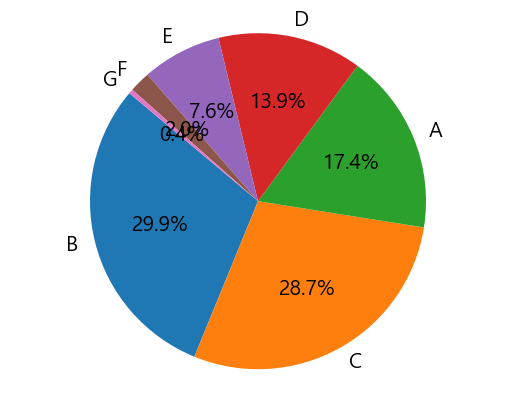

In [15]:
y_train_counts = train[target].value_counts()
plt.pie(y_train_counts, labels=y_train_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 원형을 유지하도록 하는 옵션
plt.show()
# 그래프 글씨 이것만 작게 하거나 아니면 그래프 자체를 크게 할 수 있었으면 좋겠음

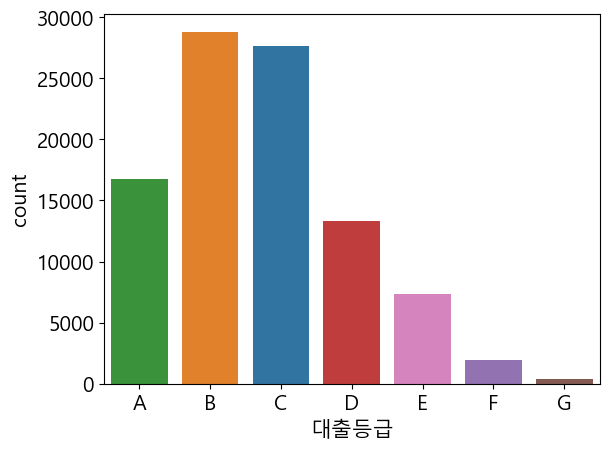

In [16]:
order_grade = ['A','B','C','D','E','F','G']
sns.countplot(x=target, data = train_df, hue = target, order=order_grade)
plt.show()

## 결측치 확인
- 근로기간에 'Unknown' 이라고 결측치가 5671개 존재

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [18]:
train_df.isna().sum()

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

In [19]:
for column in train.columns:  # 근로기간에 Unkown으로 결측치 있음
    unknown_count = (train[column] == 'Unknown').sum()
    print(f"{column}: {unknown_count}")

대출금액: 0
대출기간: 0
근로기간: 5671
주택소유상태: 0
연간소득: 0
부채_대비_소득_비율: 0
총계좌수: 0
대출목적: 0
최근_2년간_연체_횟수: 0
총상환원금: 0
총상환이자: 0
총연체금액: 0
연체계좌수: 0
대출등급: 0


In [20]:
for column in real_test.columns:  # 근로기간에 Unkown으로 결측치 있음
    unknown_count = (real_test[column] == 'Unknown').sum()
    print(f"{column}: {unknown_count}")

대출금액: 0
대출기간: 0
근로기간: 3862
주택소유상태: 0
연간소득: 0
부채_대비_소득_비율: 0
총계좌수: 0
대출목적: 0
최근_2년간_연체_횟수: 0
총상환원금: 0
총상환이자: 0
총연체금액: 0
연체계좌수: 0


## 기술통계를 통한 EDA

In [21]:
train.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [22]:
train.describe(include='O')

,대출기간,근로기간,주택소유상태,대출목적,대출등급
count,96294,96294,96294,96294,96294
unique,2,12,4,12,7
top,36 months,10+ years,MORTGAGE,부채 통합,B
freq,64479,32481,47934,55150,28817


In [23]:
# display(train_df[train_df['연간소득']==0])

## 시각화를 통한 EDA

### 수치형 데이터 시각화

In [24]:
numeric_col

['대출금액',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수']

In [25]:
for check_col in numeric_col+category_col: # numeric_col의 경우는 그냥 리스트가 아니라 index의 리스트형태?로 되어있어서 list붙여줌
    # print(check_col, " : ", len(set(X_train[check_col]))) # 중복없이 값종류 갯수
    print(check_col, " : ", len(train[check_col].unique())) # 중복없이 값종류 갯수

대출금액  :  1340
연간소득  :  7726
부채_대비_소득_비율  :  4025
총계좌수  :  109
최근_2년간_연체_횟수  :  20
총상환원금  :  27797
총상환이자  :  35626
총연체금액  :  109
연체계좌수  :  4
대출기간  :  2
근로기간  :  12
주택소유상태  :  4
대출목적  :  12


대출금액  bin :  68
연간소득  bin :  100
부채_대비_소득_비율  bin :  100
총계좌수  bin :  253
최근_2년간_연체_횟수  bin :  20
총상환원금  bin :  100
총상환이자  bin :  100
총연체금액  bin :  18


C:\Users\kssg1\AppData\Local\Temp\ipykernel_19720\1025714718.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


연체계좌수  bin :  4


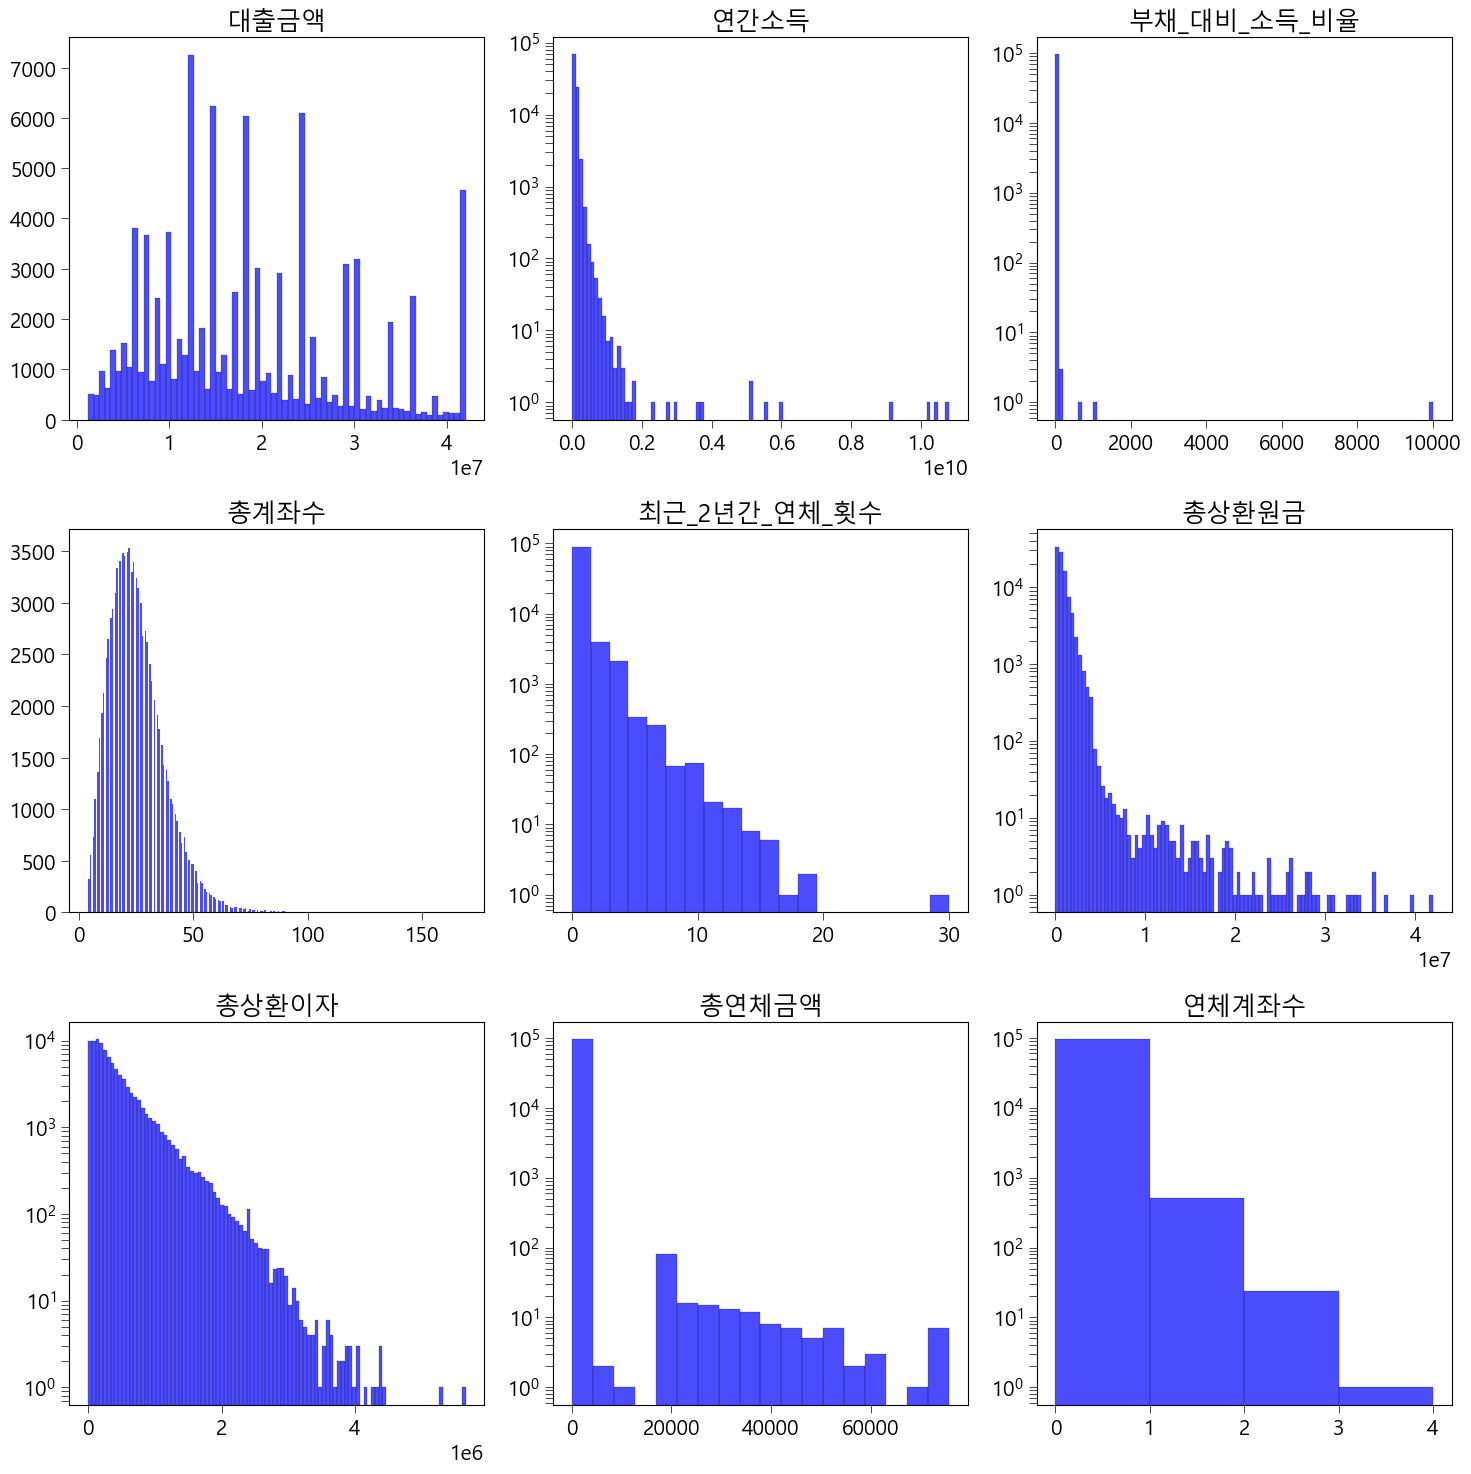

In [26]:
#수치형 변수 시각화
def get_3_hist_num(data:pd.DataFrame, columns:list, whether_log_scale: bool = True, 
                                        log_scale_threshold: float = 5000, bin_control: bool =True, num_bin_max: int = 300, num_bin_set: int = 80):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
        bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()
        n_bins = 'auto'
        
        if bin_control == True :
            # Freedman-Diaconis' Choice방식으로 bin 갯수 얼추 계산해본 뒤 판단
            entire_range = train[col].max() - train[col].min() # 데이터 값 최대와 최소 차이
            q1 = np.percentile(train[col], 25)
            q3 = np.percentile(train[col], 75)
            IQR = q3 - q1
            N = train[col].count()
            bin_width = 2 * (IQR / N**(1/3))
            num_bin = entire_range / bin_width
            # print(col, "의 bin : ", num_bin) # 점검용
            if len(set(data[col])) <= 20:
                n_bins = len(set(data[col]))
            elif (not math.isinf(num_bin)) and num_bin > num_bin_max:
                n_bins = num_bin_set
            else:
                n_bins = 'auto' # 지워도 괜찮을듯
        
        # # Wand 규칙을 사용하여 동적으로 bin의 개수 설정
        # if bar_width_ratio < bar_width_ratio_min:  # 전체 스케일에 대한 막대 두께의 비율이 너무 작으면
        #     n_bins = int(np.sqrt(len(set(data[col])))*1.0) 
        #     # 조금더 줄이면 깔끔히 잘보이지 않을까해서 0.8곱했다가 별차이없는듯해서 1.0으로 원 위치(원래 곱해진 것 따로 없었음)
        # else:
        #     n_bins = 'auto'
            
        hist, bins, _ = axes[row_idx, col_idx].hist(data[col], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7)
        num_bin_actual = len(bins) - 1  # 실제로 그려진 막대의 갯수
        #sns.histplot(data[col], ax=axes[row_idx, col_idx], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7, kde=False)
        
        axes[row_idx, col_idx].set_title(col)
        axes[row_idx, col_idx].tick_params(axis='both', which='both', direction='out', length=6, width=0.5)  # 눈금 표시
        
        bar_heights = [rect.get_height() for rect in axes[row_idx, col_idx].patches]
        max_height = max(bar_heights)
        min_height = max(min(bar_heights),1)
        
        # print(col, " 높이차는 이러함 : ", max_height / min_height, max_height, min_height) # 점검용
        print(col, " bin : ", num_bin_actual) # 점검용
        
        # 히스토그램 바의 높이 차이에 따라 리니어 스케일 또는 로그 스케일 선택
        if whether_log_scale == True and (max_height / min_height) > log_scale_threshold:
            axes[row_idx, col_idx].set_yscale('log')  # 로그 스케일로 변환
        else:
            axes[row_idx, col_idx].set_yscale('linear')  # 리니어 스케일로 유지
        
        # 전체 그래프 스케일에 대한 막대 자체의 두께 비율 계산
        total_width = axes[row_idx, col_idx].get_xlim()[1] - axes[row_idx, col_idx].get_xlim()[0]
        
        
        
        # 히스토그램 바의 두께가 조건에 따라 테두리 색 설정
        for rect in axes[row_idx, col_idx].patches:
            bar_width = rect.get_width()
            if bar_width / total_width > 0.005: # 그냥 저쯤보다 얇은 경우 테두리 없는게 나은듯해서 설정해줌
                rect.set_edgecolor('black')
            else:
                rect.set_edgecolor('none')  # 얇은 경우에는 테두리 없애기
        
        # # Seaborn axis 객체로부터 눈금 위치 확인
        # tick_locs = sns.histplot(data[col]).axes.get_xticks()
        # print(f"{col}의 현재 x 축 눈금 위치: {tick_locs}")

    # 남은 서브플롯에 빈 그래프 그리기
    for i in range(num_plots, num_rows * num_cols):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()  # 남은 서브플롯 비우기
        axes[row_idx, col_idx].axis('off')  # 빈 서브플롯 제거
        
    

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()
get_3_hist_num(train, numeric_col, log_scale_threshold=8000, num_bin_max=270, num_bin_set=100)

<Axes: xlabel='총상환이자', ylabel='Count'>

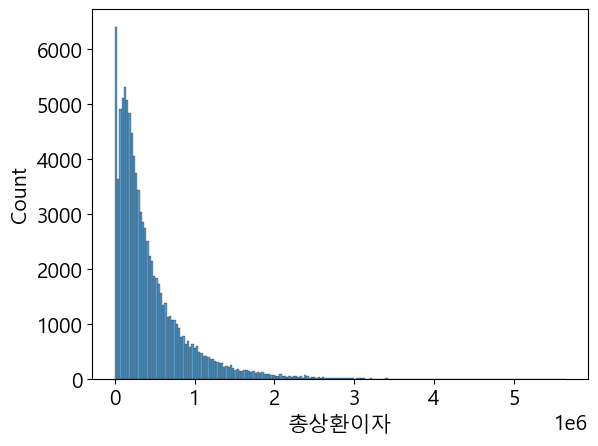

In [27]:
sns.histplot(train, x='총상환이자', bins=200)

In [28]:
train['총상환이자'].value_counts()

총상환이자
0.0          5444
156144.0       77
99312.0        73
85596.0        71
147276.0       70
             ... 
917364.0        1
774948.0        1
1131756.0       1
567804.0        1
818076.0        1
Name: count, Length: 35626, dtype: int64

In [29]:
train[train['부채_대비_소득_비율']>2000]['부채_대비_소득_비율'].value_counts() # -> 이상치로 판단

부채_대비_소득_비율
9999.0    1
Name: count, dtype: int64

In [30]:
print(train[train['최근_2년간_연체_횟수']==0]['최근_2년간_연체_횟수'].value_counts())
print(train[train['최근_2년간_연체_횟수']>0]['최근_2년간_연체_횟수'].value_counts())

최근_2년간_연체_횟수
0    76392
Name: count, dtype: int64
최근_2년간_연체_횟수
1     13079
2      3896
3      1430
4       697
5       338
6       178
7        86
8        67
9        40
10       35
11       21
12        9
14        8
13        8
16        4
18        2
15        2
17        1
30        1
Name: count, dtype: int64


In [31]:
train[train['총연체금액']<1]['총연체금액'].count()

96113

#### violin plot

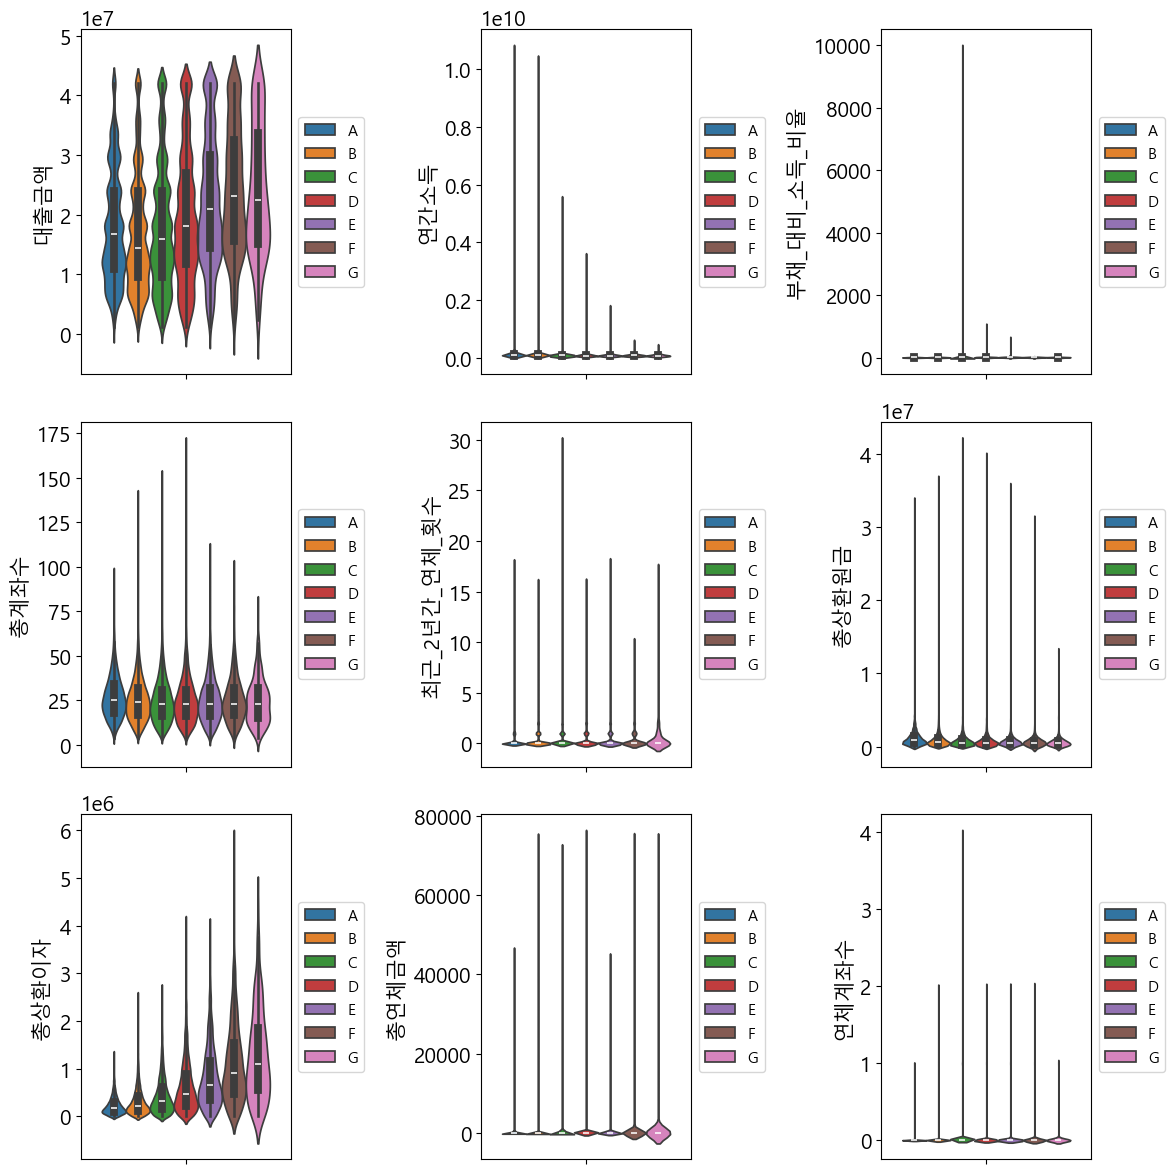

In [32]:
plt.figure(figsize=(12,12))
for idx, feature in enumerate(numeric_col):
    plt.subplot(3,3,idx+1)
    sns.violinplot(y=numeric_col[idx], hue = target, data = train_df, hue_order= order_grade)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
plt.tight_layout()
plt.show()

#### 판단
- '연간소득': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '부채_대비_소득_비율': 9999.0으로 이상치 하나 있는 것으로 판단됨
- '최근_2년간_연체_횟수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, log스케일은 할 필요 없을듯, 17이후 30이라 30을 이상치로 볼지는 염두만
- '총상환원금': 로그스케일 고려할 필요 없을듯 최소랑 최대랑 그리 막 차이 나진 않아서
- '총상환이자': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려     
-> 간격 균일하긴 한데 커질수록 살짝 퍼지는 느낌, 0제외하고는 왼쪽 쏠린 정규분포 느낌
- '총연체금액': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>, 로그스케일 고려     
-> 간격 균일하긴 한데 커질수록 살짝 퍼지는 느낌, 0제외하고는 왼쪽 쏠린 정규분포 느낌
- '연체계좌수': <u>__0인 것과 아닌 것 구분해서 범주 컬럼으로 하나 추가해주기__</u>


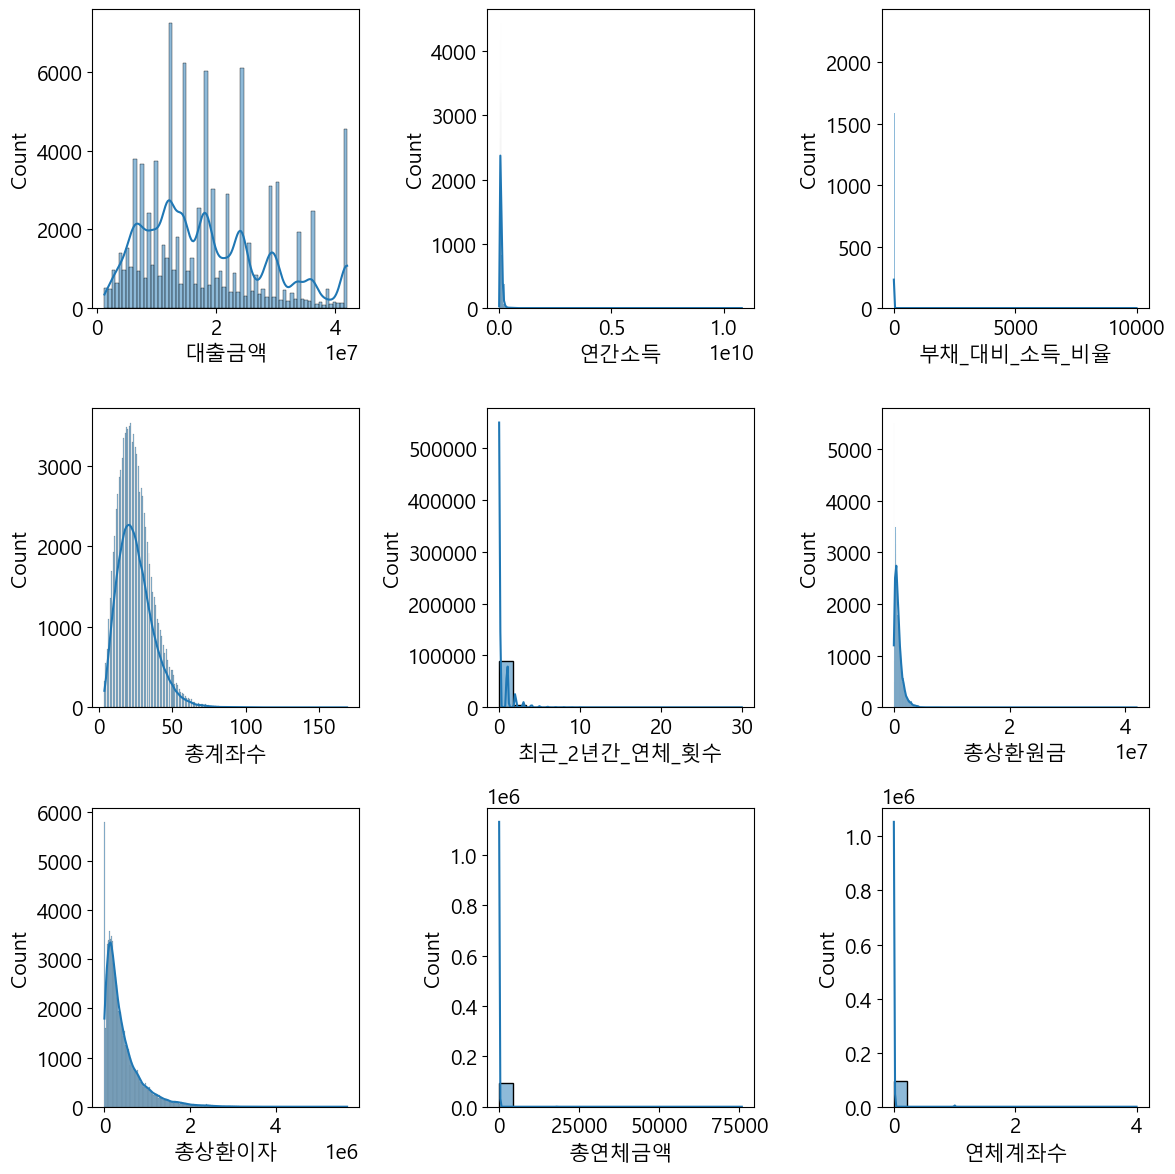

In [33]:
plt.figure(figsize=(12,12))
for idx, feature in enumerate(numeric_col):
    plt.subplot(3,3,idx+1)
    sns.histplot(x=numeric_col[idx], data = train, kde=True)
plt.tight_layout()
plt.show()

이상치가 존재하여 분포의 확인을 어렵게 함

In [34]:
# 한번 신용등급별로 수치형 데이터도 나눠서 그려볼려고 시도해봤는데 딱히 의미없이 그려진듯
# # 서브플롯에 각 변수의 대출등급 별 히스토그램 그리기
# plt.figure(figsize=(12, 12))
# for idx, feature in enumerate(numeric_col):
#     plt.subplot(3, 3, idx+1)
#     for grade in order_grade:
#         sns.histplot(train[train['대출등급'] == grade][feature], label=grade, kde=True)
#     plt.title(feature)
#     plt.legend(title='Grade')
# plt.tight_layout()
# plt.show()

### 범주형 데이터 시각화

In [35]:
# # 범주형 변수 시각화(countplot) # 개선 필요
# def get_3_countplot_category(data:pd.DataFrame, columns:list, log_scale_threshold: float = 5000):
#     """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

#     Args:
#         data (pd.DataFrame): 데이터프레임
#         columns (list): 컬럼 리스트
#         bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
#     """
#     num_plots = len(columns)
#     num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
#     num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
#     for i, col in enumerate(columns):
#         if num_rows == 1:
#             col_idx = i  # 수정된 부분
#             axes[col_idx].clear()
#             n_bins = 'auto'
#             sns.countplot(data=data, x=col, ax=axes[col_idx])  # 수정된 부분
#             max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
#             if max_length > 10:
#                 for tick in axes[col_idx][0].get_xticklabels():
#                     tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용
#         else:
#             row_idx, col_idx = divmod(i, 3)
#             axes[row_idx, col_idx].clear()
#             n_bins = 'auto'
#             sns.countplot(data=data, x=col, ax=axes[row_idx, col_idx])
#             max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
#             if max_length > 10:
#                 for tick in axes[col_idx][0].get_xticklabels():
#                     tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용

#     # 전체 그림 표시
#     plt.tight_layout()
#     plt.show()
# get_3_countplot_category(X_train, category_col)

#### 각 변수별 대출등급별로 나눠서 count plot

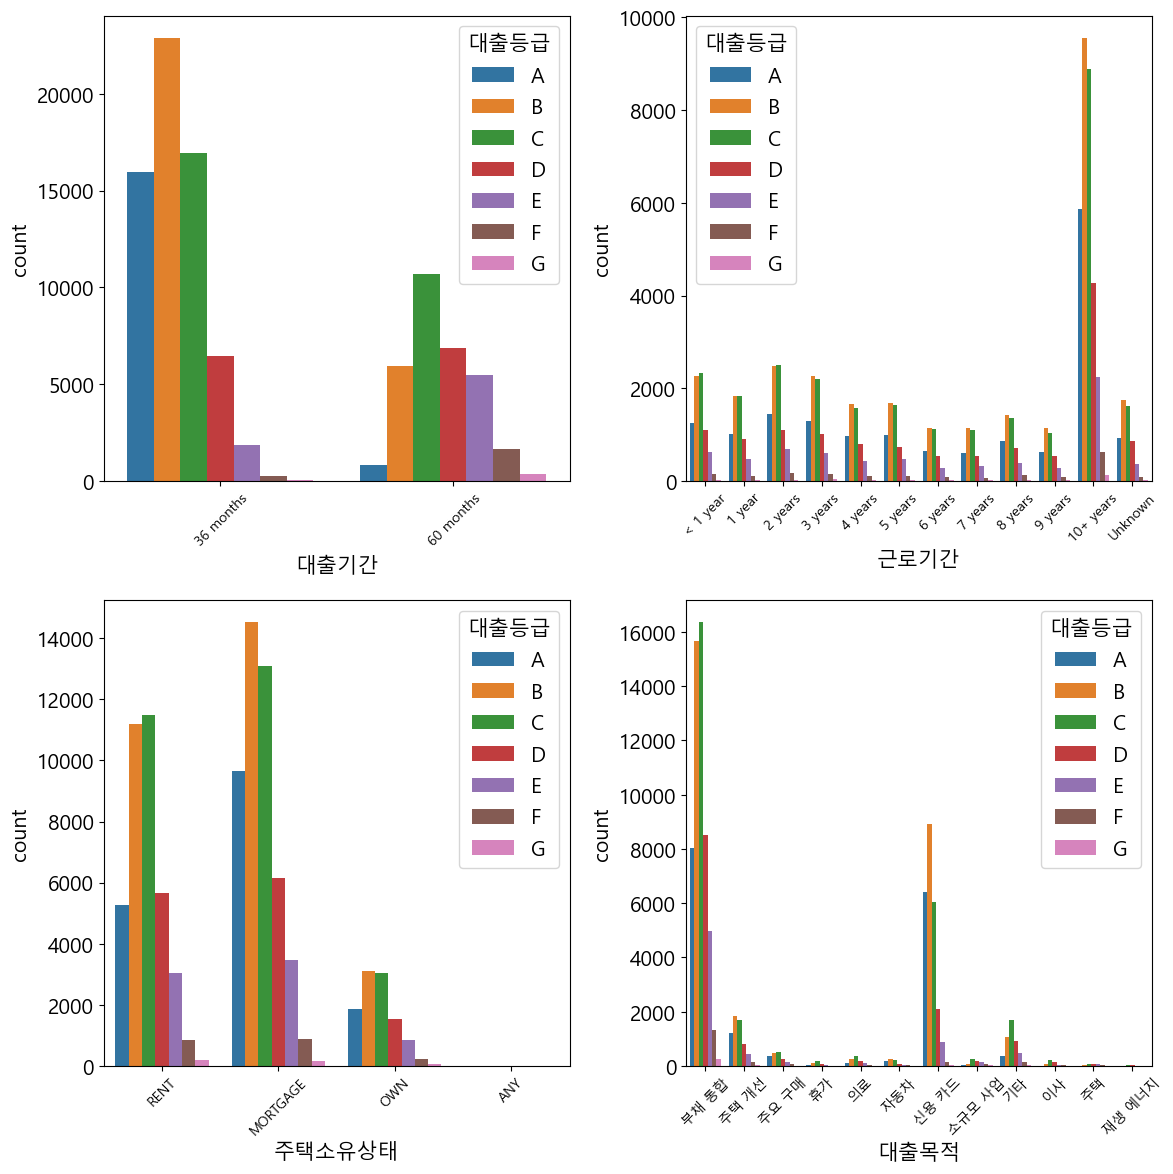

In [36]:
order_years = ['< 1 year','1 year', '2 years', '3 years', '4 years', '5 years', '6 years', 
               '7 years', '8 years', '9 years', '10+ years', 'Unknown']

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.countplot(x=category_col[0], hue=target, data=train_df, hue_order=order_grade)
plt.gca().set_xticks(range(len(train_df[category_col[0]].unique())))  # x축 위치 설정 # 경고 해결하기 위해서 추가한 부분
plt.gca().set_xticklabels(train_df[category_col[0]].unique(), fontsize=10, rotation=45)  # x축 라벨 설정

plt.subplot(2,2,2)
sns.countplot(x=category_col[1], hue=target, data=train_df, order=order_years, hue_order=order_grade)
plt.gca().set_xticks(range(len(order_years)))  # x축 위치 설정 # x축 위치 설정 # 경고 해결하기 위해서 추가한 부분
plt.gca().set_xticklabels(order_years, fontsize=10, rotation=45)  # x축 라벨 설정

plt.subplot(2,2,3)
sns.countplot(x=category_col[2], hue=target, data=train_df, hue_order=order_grade)
plt.gca().set_xticks(range(len(train_df[category_col[2]].unique())))  # x축 위치 설정 # x축 위치 설정 # 경고 해결하기 위해서 추가한 부분
plt.gca().set_xticklabels(train_df[category_col[2]].unique(), fontsize=10, rotation=45)  # x축 라벨 설정

plt.subplot(2,2,4)
sns.countplot(x=category_col[3], hue=target, data=train_df, hue_order=order_grade)
plt.gca().set_xticks(range(len(train_df[category_col[3]].unique())))  # x축 위치 설정 # x축 위치 설정 # 경고 해결하기 위해서 추가한 부분
plt.gca().set_xticklabels(train_df[category_col[3]].unique(), fontsize=10, rotation=45)  # x축 라벨 설정

plt.tight_layout()
plt.show()


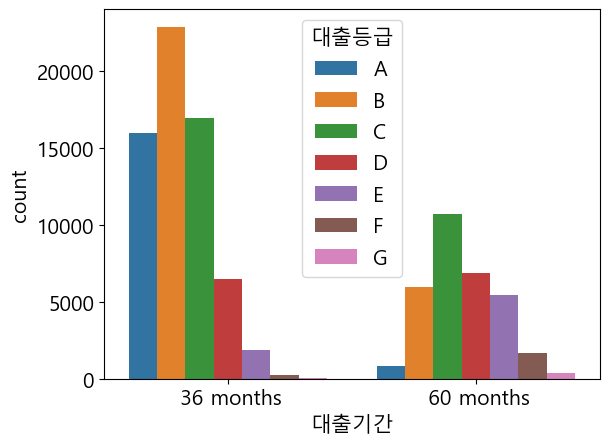

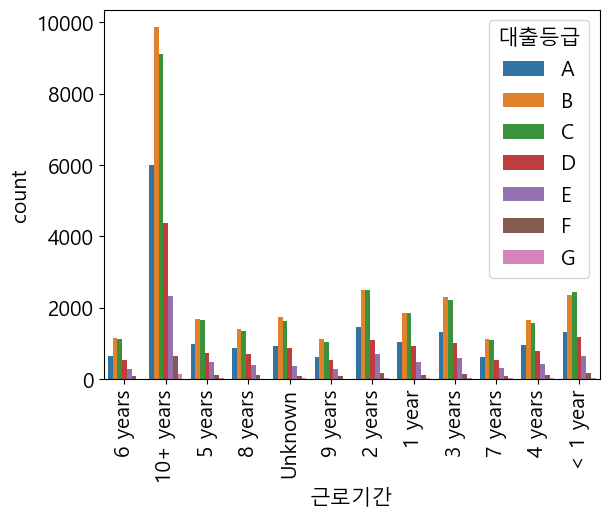

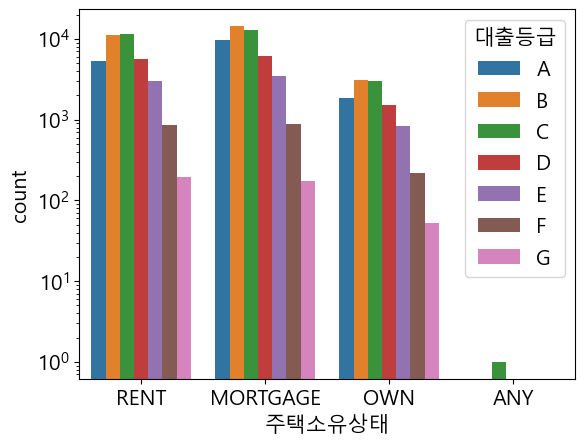

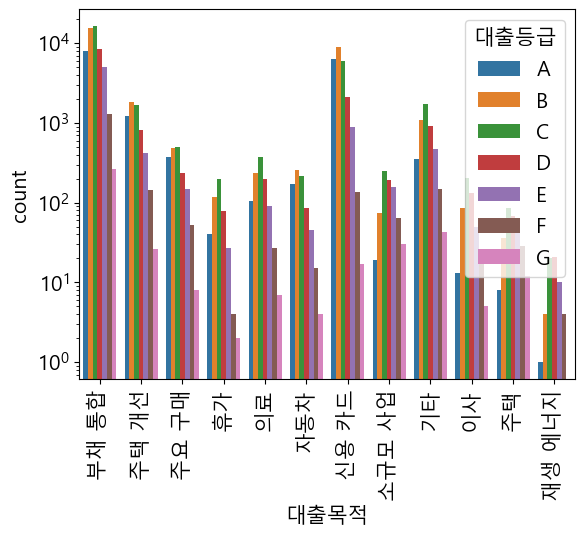

In [37]:
for plot_col in category_col:
    sns.countplot(data = train, x=plot_col, hue=target, hue_order=order_grade)
    if plot_col in ['근로기간', '대출목적']:
        plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
    if plot_col in ['주택소유상태', '대출목적']:
        plt.yscale('log')  # y축을 로그 스케일로 변환
    plt.show()

In [38]:
train[train['주택소유상태']=='ANY']['주택소유상태'].count()

1

#### 각 범주별 상대도수를 나타내는 heat map (피쳐 vs 타겟)

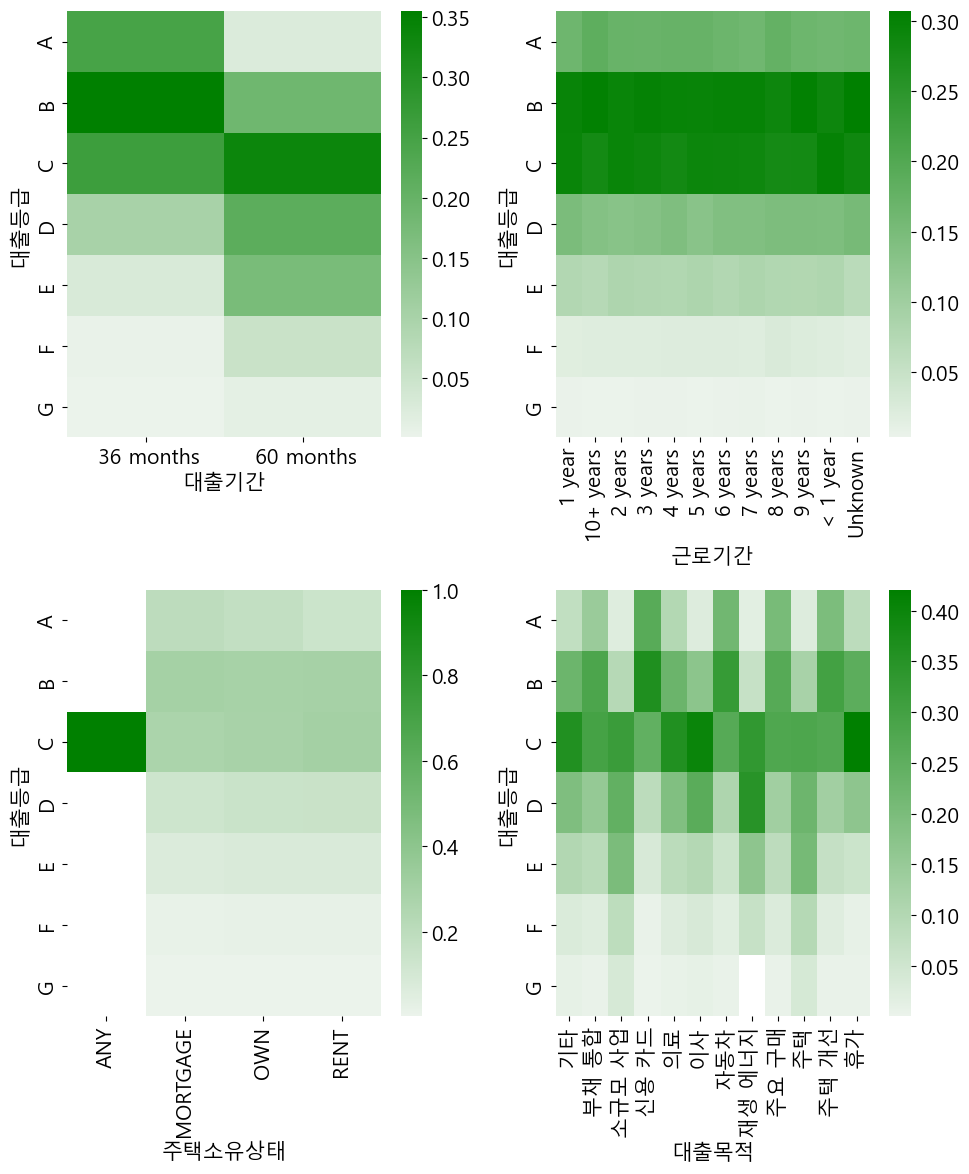

In [39]:
plt.figure(figsize=(10,12))
for idx, feature in enumerate(category_col):
    plt.subplot(2,2,idx+1)
    pivot = train.pivot_table(index=feature, columns = target, 
                                 aggfunc="size")
    pivot['sum'] = pivot.sum(axis=1)
    for column in pivot.columns:
        pivot[column] = pivot[column] / pivot['sum']
    pivot = pivot.drop('sum',axis=1).T
    sns.heatmap(pivot, cmap=sns.light_palette('Green',as_cmap=True), annot=False)
plt.tight_layout()
plt.show()

# Unknown 어디갔어?? (형식 일치 안시켜놔서 그런 것 같음)

위를 통해 근로시간과 주택 소유 상태는 대출등급에 거의 영향을 주지 않음을 확인할 수 있을 듯함

#### 주택소유상태 표시 의미
주택 소유 상태를 나타내는 단어에서 각각의 의미는 다음과 같습니다:

RENT (임대): 주택을 소유하지 않고 대신 임대(또는 전세)하는 상태를 나타냅니다. 임차인은 일정 기간 동안 주택을 사용할 수 있지만 소유권은 없습니다.    
MORTGAGE (담보): 주택을 구매하기 위해 대출을 받고, 그 주택을 담보로 제공하는 상태를 나타냅니다. 대출을 상환하면서 주택의 소유권은 점차 대출을 상환하는 사람(대출자)에게 이전됩니다.     
OWN (소유): 주택을 소유하고 있는 상태를 나타냅니다. 소유자는 주택의 완전한 소유 및 권한을 가지며, 언제든지 주택을 판매하거나 대여할 수 있습니다.    
ANY (어느 것도 아닌): "ANY"는 일반적으로 선택지가 없음을 나타내며, 주택 소유 상태를 명시적으로 나타내지 않는 경우에 사용될 수 있습니다. 

In [40]:
train[train['대출목적']=='재생 에너지']['대출목적'].count()

60

# 데이터 전처리
- 이상치
	- 판단 기준: 	
		- z-score, IQR, ESD 등등
	- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거
- 결측치
	- 근로기간 결측치 Unknown 처리 고민 , Unkown형태는 없었지만 더 확인해볼 필요는 있을듯
- <strike>값 형식 불일치
	- 근로기간 값 형식이 일치 안된 것이 많아서
		- 10+years를 10+ years 로 통일시켜주기
		- < 1 year를 <1 year로 통일시켜주거나, 아니면 0 year로 통일시켜주기
		- 1 years를 1 year로 통일시켜주기
		- 3을 3 years로 통일시켜주기 </strike>
- 데이터 형식 바꿔주기
	- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기
- <strike>데이터 비율 맞춰주기 위해 Oversampleing
	- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
    - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용</strike>
- 컬럼 분리
	- 최근_2년간_연체_횟수, 총상환이자, 총연체금액, 연체계좌수 : 0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기

- 스케일링
	- 수동 로그스케일링:
		- <strike>총연체금액: 로그스케일링해주기</strike> -> 불필요할듯하여 취소
	- 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
		- 표준화(sd_sc): '연간소득'?, '부채_대비_소득_비율'? ->조금 애매함 튜터님과 상의
		- 정규화(mm_sc): '대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
- 인코딩
	- y 변수 인코딩: 
	- 순서가 중요한 순서형 데이터: (map이나 다른 패키지의 모듈 사용)
	- 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
	- 원-핫 인코딩 : 주택소유상태, 대출목적
		- get_dummy:
		- 원-핫 인코딩:

## 이상치 제거
- 부채_대비_소득_비율 9999.0로 이상치 하나 존재 제거

### 기존 방식

In [41]:
# 2000이상으로 값이 9999.0 하나 밖에 존재하지 않음
# 제거하고 나도 조금 떨어져 있는 듯한 녀석들이 있어서 전에 전처리 개인과제때 이상치 제거 함수 가져와서 통계적인 방법으로 이상치 제거하는게 나을듯
def to_remove_Outlier(data:pd.DataFrame = train): # train 데이터에 대해서만 해주면 될듯
    data = data[data['부채_대비_소득_비율']<3000] #<600
    return data
# X_train = to_remove_Outlier(X_train) # 이건 또 지역변수로 되었는지 값 반영안되서 반영

In [42]:
def check_outliers_in_columns(data: pd.DataFrame, numeric_col: list, threshold: float = 1.5) -> dict:
    """
    주어진 열 리스트에 대해 각각 이상치가 있는지 없는지 확인하는 함수

    Args:
        data (pd.DataFrame): 대상 데이터프레임
        numeric_col (list): 이상치를 확인할 수치형 열의 리스트
        threshold (float): 이상치를 판단하는 기준 값. 기본값은 1.5.
        -> Q3, Q1에서 상, 하향으로 IQR*1.5배 떨어지면 상, 하향 이상치로 판단한다

    Returns:
        dict: 각 열의 이상치 존재 여부를 담은 딕셔너리. 이상치가 있으면 True, 없으면 False
    """
    outliers_dict = {}

    for column in numeric_col:
        # 해당 열의 1사분위수(Q1)와 3사분위수(Q3) 계산
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)

        # IQR 계산
        IQR = Q3 - Q1

        # 이상치의 상한, 하한 값 계산
        upper_bound = Q3 + threshold * IQR
        lower_bound = Q1 - threshold * IQR

        # 이상치 여부 확인
        outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
        has_outliers = outliers.any()

        # 이상치 여부를 딕셔너리에 저장
        outliers_dict[column] = has_outliers

        # 이상치가 있으면, 이상치의 개수와 비율 출력
        if has_outliers:
            outliers_count = outliers.sum()
            outliers_ratio = outliers_count / len(data) * 100
            print(f"'{column}' 열에는 {outliers_count}개의 이상치가 있어, 전체의 {outliers_ratio:.2f}%가 이상치입니다")
        else :
            print(f"'{column}' 열에는 이상치가 없습니다.")

    return outliers_dict


# 각 열에 대해 이상치 확인
outliers_dict = check_outliers_in_columns(train, numeric_col)
print(outliers_dict)


'대출금액' 열에는 이상치가 없습니다.
'연간소득' 열에는 4347개의 이상치가 있어, 전체의 4.51%가 이상치입니다
'부채_대비_소득_비율' 열에는 30개의 이상치가 있어, 전체의 0.03%가 이상치입니다
'총계좌수' 열에는 2097개의 이상치가 있어, 전체의 2.18%가 이상치입니다
'최근_2년간_연체_횟수' 열에는 19902개의 이상치가 있어, 전체의 20.67%가 이상치입니다
'총상환원금' 열에는 5196개의 이상치가 있어, 전체의 5.40%가 이상치입니다
'총상환이자' 열에는 5878개의 이상치가 있어, 전체의 6.10%가 이상치입니다
'총연체금액' 열에는 181개의 이상치가 있어, 전체의 0.19%가 이상치입니다
'연체계좌수' 열에는 532개의 이상치가 있어, 전체의 0.55%가 이상치입니다
{'대출금액': False, '연간소득': True, '부채_대비_소득_비율': True, '총계좌수': True, '최근_2년간_연체_횟수': True, '총상환원금': True, '총상환이자': True, '총연체금액': True, '연체계좌수': True}


In [43]:
def replace_outliers_in_columns_iqr(data: pd.DataFrame, numeric_col: list, threshold: float = 1.5, fill_with: str = 'mean') -> pd.DataFrame:
    """
    주어진 열 리스트에 대해 각각 IQR을 이용하여 이상치를 대체하는 함수

    Args:
        data (pd.DataFrame): 대상 데이터프레임
        numeric_col (list): 이상치를 확인할 수치형 열의 리스트
        threshold (float): 이상치를 판단하는 기준 값. 기본값은 1.5. 
        -> Q3, Q1에서 상, 하향으로 IQR*1.5배 떨어지면 상, 하향 이상치로 판단한다
        fill_with (str): 이상치를 대체할 값의 종류. 기본값은 'mean'. 'median', 'mode' 가능

    Returns:
        pd.DataFrame: 이상치가 대체된 데이터프레임
    """
    data_filled = data.copy()

    for column in numeric_col:
        # 해당 열의 1사분위수(Q1)와 3사분위수(Q3) 계산
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)

        # IQR 계산
        IQR = Q3 - Q1

        # 이상치의 상한, 하한 값 계산
        upper_bound = Q3 + threshold * IQR
        lower_bound = Q1 - threshold * IQR

        # 이상치를 대체할 값 결정
        if fill_with == 'mean':
            fill_value = data[column].mean()
        elif fill_with == 'median':
            fill_value = data[column].median()
        elif fill_with == 'mode':
            fill_value = data[column].mode()[0]
        else:
            raise ValueError("'fill_with'는 'mean', 'median', 'mode' 중 하나여야 합니다")

        # 이상치 찾기
        outliers = (data_filled[column] < lower_bound) | (data_filled[column] > upper_bound)

        # 이상치 대체 전 이상치의 개수 계산 및 출력
        outliers_count_before = outliers.sum()
        print(f"'{column}' 열에서 대체될 이상치의 갯수: {outliers_count_before}")

        # 이상치 대체
        data_filled.loc[outliers, column] = fill_value

    return data_filled

# 각 열에 대해 이상치 대체 적용
#X_train_no_outliers = replace_outliers_in_columns_iqr(X_train, numeric_col, fill_with='mean')
# X_train_no_outliers = replace_outliers_in_columns_iqr(train, ['부채_대비_소득_비율'], fill_with='mean')
# X_train = X_train_no_outliers


### z-score 방식

In [44]:
def check_zscore_outliers(data: pd.DataFrame, numeric_col: list, threshold: float = 3.0) -> dict:
    """
    주어진 열 리스트에 대해 각각 z-score를 사용하여 이상치가 있는지 없는지 확인하는 함수

    Args:
        data (pd.DataFrame): 대상 데이터프레임
        numeric_col (list): 이상치를 확인할 수치형 열의 리스트
        threshold (float): 이상치를 판단하는 기준 값. 기본값은 3.0.
        -> 절대값 z-score가 기준값을 넘어가면 이상치로 판단한다

    Returns:
        dict: 각 열의 이상치 존재 여부를 담은 딕셔너리. 이상치가 있으면 True, 없으면 False
    """
    outliers_dict = {}

    for column in numeric_col:
        # 해당 열의 z-score 계산
        z_scores = (data[column] - data[column].mean()) / data[column].std()

        # 이상치 여부 확인
        outliers = abs(z_scores) > threshold
        has_outliers = outliers.any()

        # 이상치 여부를 딕셔너리에 저장
        outliers_dict[column] = has_outliers

        # 이상치가 있으면, 이상치의 개수와 비율 출력
        if has_outliers:
            outliers_count = outliers.sum()
            outliers_ratio = outliers_count / len(data) * 100
            print(f"'{column}' 열에는 {outliers_count}개의 이상치가 있어, 전체의 {outliers_ratio:.2f}%가 이상치입니다")
        else:
            print(f"'{column}' 열에는 이상치가 없습니다.")

    return outliers_dict

# 각 열에 대해 z-score 이상치 확인, threshold 값으로 이상치 비율 조정
zscore_outliers_dict = check_zscore_outliers(train, numeric_col)
print(zscore_outliers_dict)

'대출금액' 열에는 이상치가 없습니다.
'연간소득' 열에는 494개의 이상치가 있어, 전체의 0.51%가 이상치입니다
'부채_대비_소득_비율' 열에는 5개의 이상치가 있어, 전체의 0.01%가 이상치입니다
'총계좌수' 열에는 949개의 이상치가 있어, 전체의 0.99%가 이상치입니다
'최근_2년간_연체_횟수' 열에는 1497개의 이상치가 있어, 전체의 1.55%가 이상치입니다
'총상환원금' 열에는 667개의 이상치가 있어, 전체의 0.69%가 이상치입니다
'총상환이자' 열에는 2012개의 이상치가 있어, 전체의 2.09%가 이상치입니다
'총연체금액' 열에는 180개의 이상치가 있어, 전체의 0.19%가 이상치입니다
'연체계좌수' 열에는 532개의 이상치가 있어, 전체의 0.55%가 이상치입니다
{'대출금액': False, '연간소득': True, '부채_대비_소득_비율': True, '총계좌수': True, '최근_2년간_연체_횟수': True, '총상환원금': True, '총상환이자': True, '총연체금액': True, '연체계좌수': True}


In [45]:
z_scores = stats.zscore(train[numeric_col].drop(['총연체금액','연체계좌수'], axis = 1))
outlier_ratio = {}
threshold_to_try = {}
for threshold in np.linspace(3,10,71):
    outliers_z = train.drop(['총연체금액','연체계좌수'],axis=1)[(z_scores > threshold).any(axis=1)]
    train_drop_outlier = train[(z_scores < threshold).all(axis=1)].copy()

    outlier_ratio[threshold] = round(len(outliers_z)/len(train) * 100,4)
    threshold_to_try[threshold] = train_drop_outlier
outlier_ratio

{3.0: 5.6099,
 3.1: 5.2319,
 3.2: 4.8705,
 3.3: 4.4219,
 3.4: 4.1498,
 3.5: 3.9847,
 3.6: 3.7967,
 3.7: 3.6108,
 3.8: 3.4478,
 3.9: 3.265,
 4.0: 2.4404,
 4.1: 2.3449,
 4.2: 2.2203,
 4.3: 2.1216,
 4.4: 2.0385,
 4.5: 1.9129,
 4.6: 1.8402,
 4.7: 1.7696,
 4.8: 1.7125,
 4.9: 1.6543,
 5.0: 1.5972,
 5.1: 1.1891,
 5.2: 1.1382,
 5.300000000000001: 1.1143,
 5.4: 1.0759,
 5.5: 1.0458,
 5.6: 1.0229,
 5.7: 0.9783,
 5.800000000000001: 0.9585,
 5.9: 0.9357,
 6.0: 0.9201,
 6.1: 0.9035,
 6.2: 0.7072,
 6.300000000000001: 0.6802,
 6.4: 0.6667,
 6.5: 0.6584,
 6.6: 0.647,
 6.7: 0.6366,
 6.800000000000001: 0.6241,
 6.9: 0.6086,
 7.0: 0.6034,
 7.1000000000000005: 0.5961,
 7.2: 0.5867,
 7.3: 0.4922,
 7.4: 0.4912,
 7.5: 0.4787,
 7.6000000000000005: 0.4756,
 7.7: 0.4704,
 7.800000000000001: 0.4673,
 7.9: 0.4642,
 8.0: 0.46,
 8.100000000000001: 0.4507,
 8.2: 0.4486,
 8.3: 0.4434,
 8.4: 0.3718,
 8.5: 0.3666,
 8.600000000000001: 0.3645,
 8.7: 0.3572,
 8.8: 0.3541,
 8.9: 0.35,
 9.0: 0.3469,
 9.100000000000001: 0.34

In [46]:
threshold_to_try

{3.0:            대출금액        대출기간       근로기간    주택소유상태       연간소득  부채_대비_소득_비율  \
 0      12480000   36 months    6 years      RENT   72000000        18.90   
 1      14400000   60 months  10+ years  MORTGAGE  130800000        22.33   
 2      12000000   36 months    5 years  MORTGAGE   96000000         8.60   
 3      14400000   36 months    8 years  MORTGAGE  132000000        15.09   
 4      18000000   60 months    Unknown      RENT   71736000        25.39   
 ...         ...         ...        ...       ...        ...          ...   
 96289  14400000   36 months  10+ years  MORTGAGE  210000000         9.33   
 96290  28800000   60 months  10+ years  MORTGAGE  132000000         5.16   
 96291  14400000   36 months     1 year  MORTGAGE   84000000        11.24   
 96292  15600000   36 months    5 years  MORTGAGE   66330000        17.30   
 96293   8640000   36 months  10+ years      RENT   50400000        11.80   
 
        총계좌수   대출목적  최근_2년간_연체_횟수    총상환원금     총상환이자  총연체금액  연체계좌수 대출

3.0


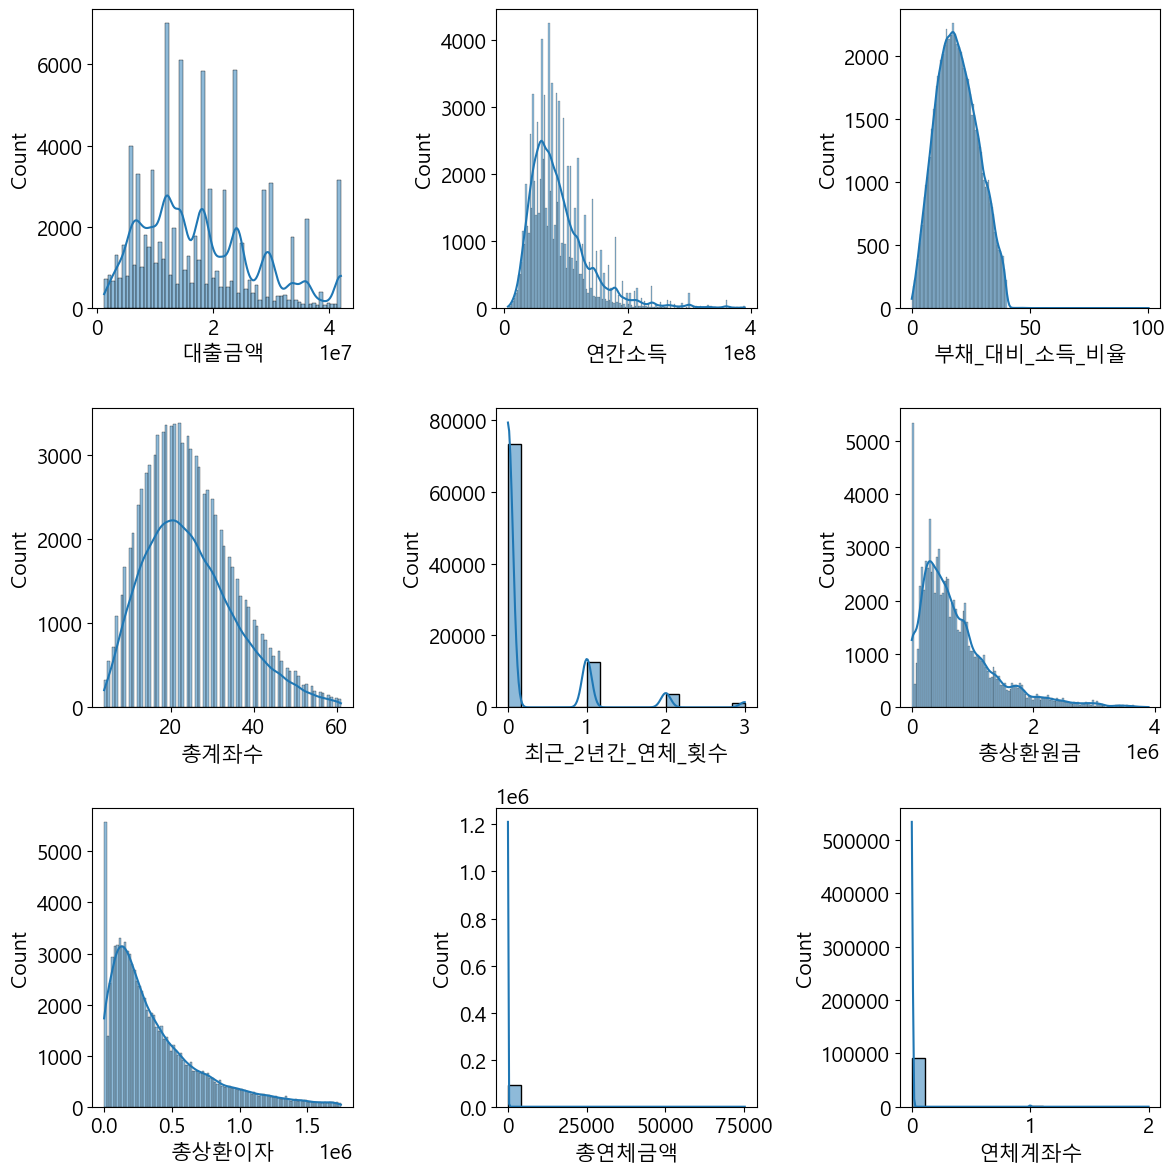

10.0


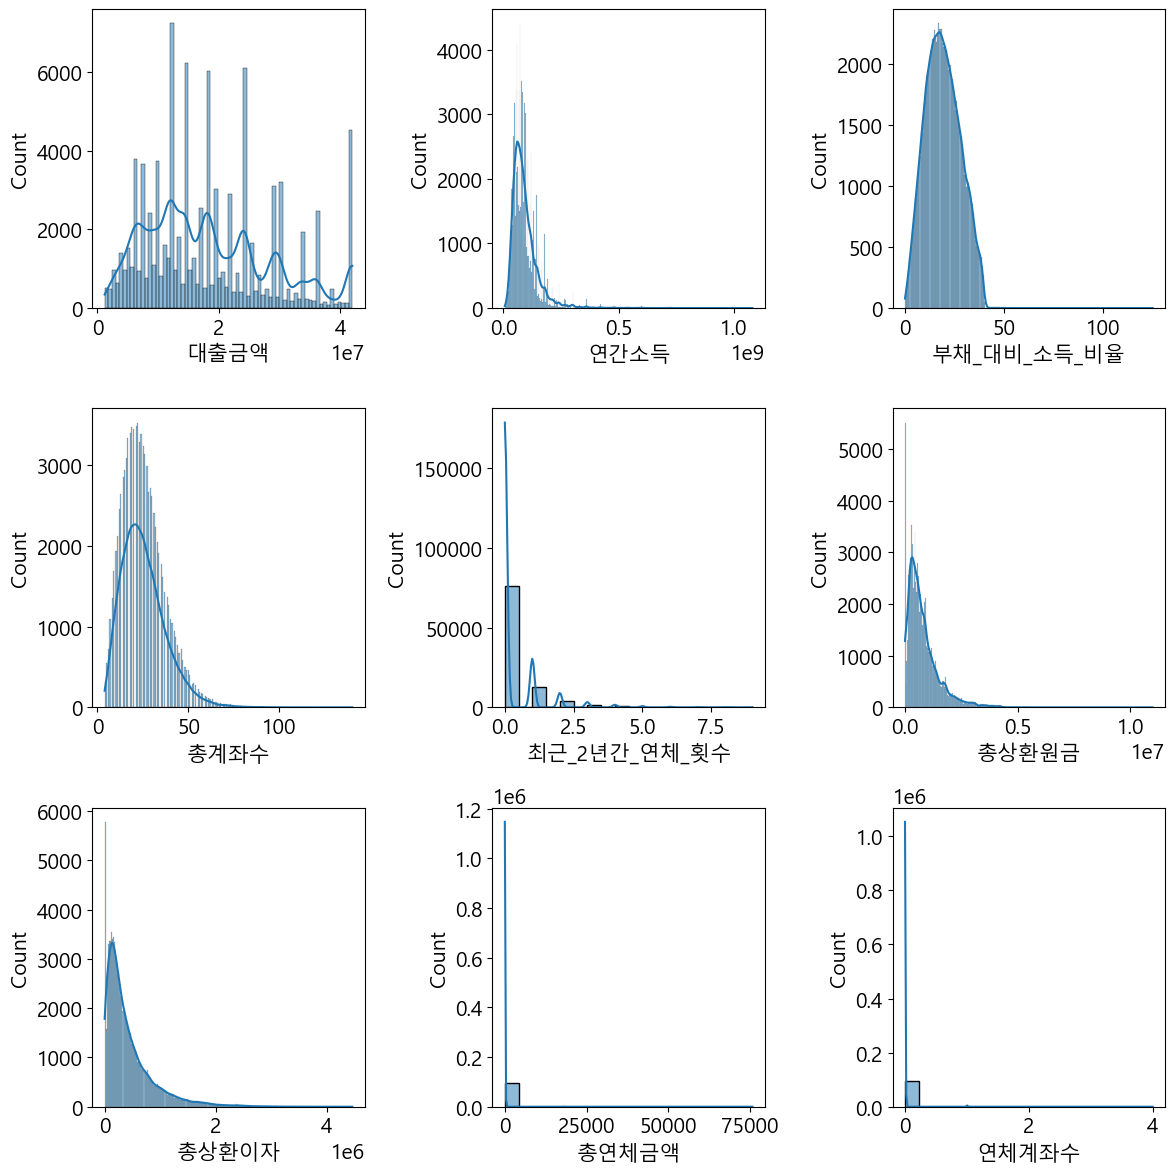

7.0


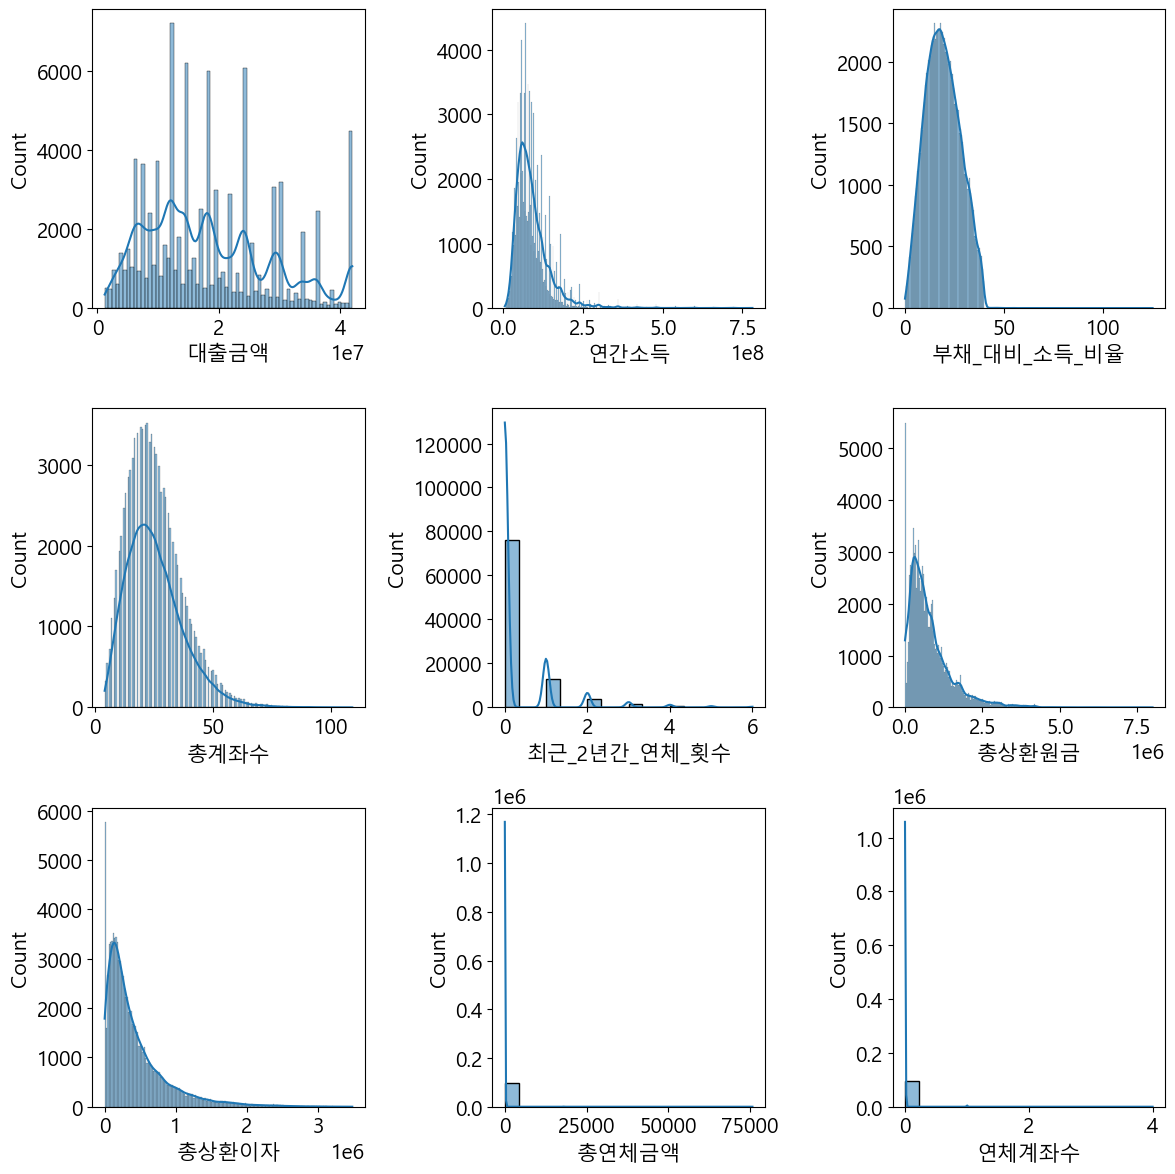

In [47]:
def z_score_control(threshold:float) :
    train_del_outlier_try = threshold_to_try[threshold]
    plt.figure(figsize=(12,12))
    for idx in range(len(numeric_col)):
        plt.subplot(3,3,idx+1)
        sns.histplot(x=numeric_col[idx], data = train_del_outlier_try, kde=True)
    plt.tight_layout()
    print(threshold)
    plt.show()
    return train_del_outlier_try

train_del_outlier_try1 = z_score_control(3.0)
train_del_outlier_try2 = z_score_control(10.0)
train_del_outlier_try3 = z_score_control(7.0)

In [48]:
outlier_ratio[7.0] # 7.0기준으로 초과하는 데이터 제거시 전체의 0.6034에 해당하는 데이터가 제거됨

0.6034

왜인지는 모르겠지만  z-score 기반 이상치 처리 후에도,   
부채_대비_소득_비율은 약 45이상의 값에서 데이터 전반 경향성에서 벗어난 데이터들이 포착됩니다    
이것이 중요한지 안한지는 모르겠으나 값을 살펴보면 45정도에서 확 떨어지기 시작하므로 그것을 기준으로 잡고 이상치로 취급하였음

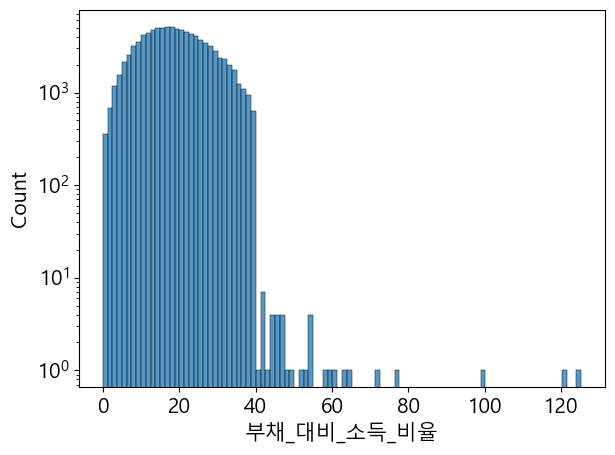

In [49]:
sns.histplot(x='부채_대비_소득_비율', data = train[train['부채_대비_소득_비율']<200], bins=100)
plt.yscale('log') # y축 스케일을 로그 스케일로 변경
plt.tight_layout()
plt.show()

In [50]:
train_del_outlier_try3[train_del_outlier_try3['부채_대비_소득_비율']>45].shape[0]

26

In [51]:
filter = ((z_scores > 7.0).any(axis=1)) | (train['부채_대비_소득_비율']>45)
outliers = train.copy()[filter]
train_prep = train.copy()[~filter]

In [52]:
train_prep.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.568700e+04,9.568700e+04,95687.000000,95687.000000,95687.000000,9.568700e+04,9.568700e+04,95687.000000,95687.000000
mean,1.828355e+07,9.243149e+07,19.268147,25.250337,0.319657,7.931892e+05,4.265763e+05,51.803526,0.005675
std,1.031497e+07,5.795513e+07,8.694260,12.023704,0.775177,7.180622e+05,4.345672e+05,1360.286663,0.079049
min,1.200000e+06,6.000000e+06,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.736000e+07,12.660000,17.000000,0.000000,3.066900e+05,1.344120e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.760000,24.000000,0.000000,5.952600e+05,2.864160e+05,0.000000,0.000000
75%,2.400000e+07,1.116000e+08,25.560000,32.000000,0.000000,1.049544e+06,5.689860e+05,0.000000,0.000000
max,4.200000e+07,7.812000e+08,44.890000,109.000000,6.000000,8.007588e+06,3.483276e+06,75768.000000,4.000000


In [53]:
# X_train['부채_대비_소득_비율'].skew()

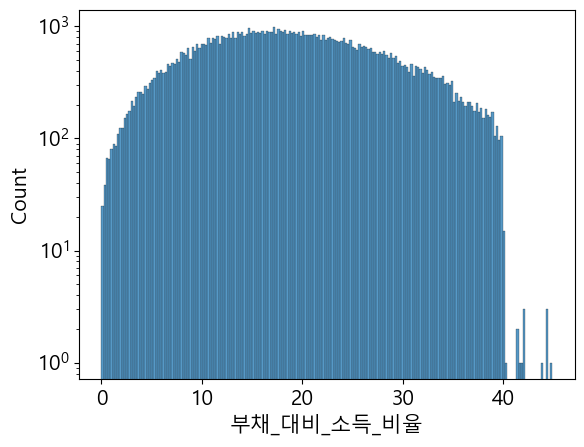

In [54]:
# 이상치 제거후 확인
sns.histplot(data=train_prep, x='부채_대비_소득_비율', bins=200)
plt.yscale('log')
plt.show()

##  결측치 처리
- 제거하거나 최빈값으로 대치해주면 될듯하나 일단 패스
- 근로기간 결측치 Unknown 처리 고민 , Unkown형태는 없었지만 더 확인해볼 필요는 있을듯
    - 각 범주의 갯수의 평균 약 6018인데 Unknown의 갯수는 5670 이며  
        대략 확 차이나는 것이 3744와 896으로 확 뛰어서 3000개 이상인 것들에 대해서만 평균 내면 약 7907임    
        총 96293개 중 5670개이므로 5.89%정도 됨

In [55]:
(5670/train_prep['근로기간'].count())*100

5.925569826622216

In [56]:
# '근로기간' 열의 값 빈도 계산
value_counts = train_prep['근로기간'].value_counts()
print("값의 빈도:", value_counts)
# 빈도가 3000개를 초과하는 값을 선택하여 출력
selected_values = value_counts[value_counts > 3000]
print("3000개를 초과하는 값들:")
print(selected_values)
print("3000개 초과하는 값들의 평균:", selected_values.mean())

값의 빈도: 근로기간
10+ years    32253
2 years       8380
< 1 year      8107
3 years       7622
1 year        6263
Unknown       5649
5 years       5631
4 years       5564
8 years       4861
6 years       3851
7 years       3780
9 years       3726
Name: count, dtype: int64
3000개를 초과하는 값들:
근로기간
10+ years    32253
2 years       8380
< 1 year      8107
3 years       7622
1 year        6263
Unknown       5649
5 years       5631
4 years       5564
8 years       4861
6 years       3851
7 years       3780
9 years       3726
Name: count, dtype: int64
3000개 초과하는 값들의 평균: 7973.916666666667


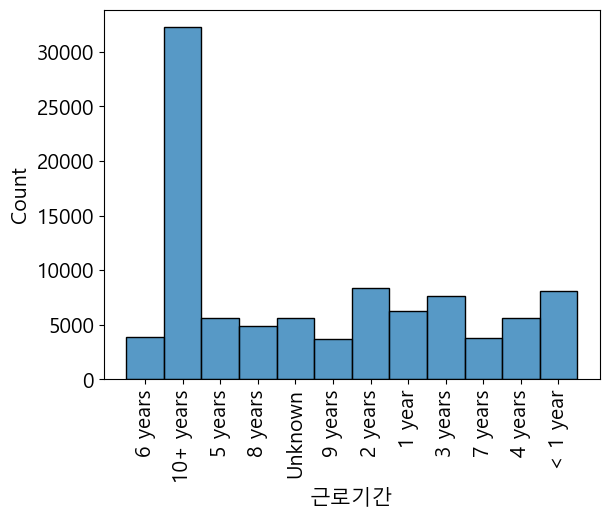

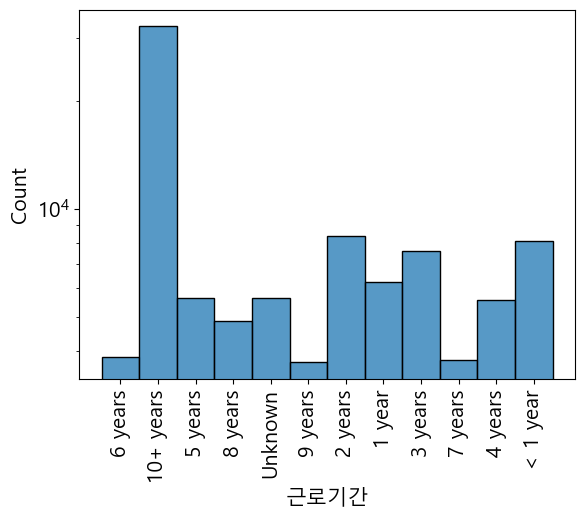

In [57]:
# 근로기간 값 확인용 그래프 두가지
sns.histplot(train_prep, x='근로기간')
plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
plt.show()
sns.histplot(train_prep, x='근로기간')
plt.xticks(rotation=90)  # 그래프 x축 라벨 45도 회전
plt.yscale('log')  # y축을 로그 스케일로 변환
plt.show()

In [58]:
def get_non_missing(data:pd.DataFrame = train_prep, option:int = 1):
    if option == 1: # 제거방식
        data=data[data['근로기간'] != 'Unknown']
    elif option == 2:
        print("아직 구현중")
    

## 데이터 형식 바꿔주기
- 범주형 데이터 object에서 category로 형식 변경, 그리고 카테고리 순서정해줄 것은 순서 정해주기
- 현재 경고가 좀 뜨는데 일단 가동자체는 문제가 없으니 후에 개선하겠음

In [59]:
# 함수화
def type_change_category(data:pd.DataFrame, columns:list):
    for col in columns:
        data[col] = data[col].astype('category')
        # ordered=False로 해주어 순서를 정해주되, 변수 자체에 순서내용까지는 포함시키지 않았다 
        # True로 하니까 무슨 <이런식으로 내용추가되는듯했음
        if col == '대출기간':
            loan_period_list = [' 36 months', ' 60 months']
            data[col] = data[col].cat.reorder_categories(loan_period_list, ordered=False)
        elif col == '근로기간':
            working_period_list = ['Unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years', 
                             '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'] #미혼, 기혼, 이혼 순으로 순서 정해줬음
            data[col] = data[col].cat.reorder_categories(working_period_list, ordered=False)
        elif col == '대출등급':
            loan_rating_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] # ['G', 'F', 'E', 'D', 'C', 'B', 'A']
            data[col] = data[col].cat.reorder_categories(loan_rating_list, ordered=False)
    return None

# object에서 category로 바꿔주는 것이 상황에 따라 다른데 지금 상황에서는 크게 이익되는 부분이 없는 듯하여 주석처리
# X_train
type_change_category(train_prep, category_col+[target]) #얘들도 알아서 전역변수로 인식되어 잘 반영되었음
# X_test
type_change_category(real_test, category_col)

In [60]:
print(train_prep.info())
print(real_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 95687 entries, 0 to 96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          95687 non-null  int64   
 1   대출기간          95687 non-null  category
 2   근로기간          95687 non-null  category
 3   주택소유상태        95687 non-null  category
 4   연간소득          95687 non-null  int64   
 5   부채_대비_소득_비율   95687 non-null  float64 
 6   총계좌수          95687 non-null  int64   
 7   대출목적          95687 non-null  category
 8   최근_2년간_연체_횟수  95687 non-null  int64   
 9   총상환원금         95687 non-null  int64   
 10  총상환이자         95687 non-null  float64 
 11  총연체금액         95687 non-null  float64 
 12  연체계좌수         95687 non-null  float64 
 13  대출등급          95687 non-null  category
dtypes: category(5), float64(4), int64(5)
memory usage: 7.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 13 columns):
 #   Column    

In [61]:
display((train_prep.head(3)))
real_test.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0


In [62]:
train_df[(train_df['ID'] == 'TRAIN_42717') | (train_df['ID'] == 'TRAIN_42625')]

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
42625,TRAIN_42625,12000000,36 months,10+ years,RENT,60000000,11.19,22,신용 카드,0,0,0.0,0.0,0.0,A
42717,TRAIN_42717,30000000,60 months,1 year,MORTGAGE,60000000,27.47,17,부채 통합,0,805248,1743384.0,0.0,0.0,F


## 데이터 비율 맞춰주기 위해 Oversampleing
- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
- SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용

In [63]:
# X_train = X_train.drop(columns=['ID'])
# smnc = SMOTENC(categorical_features=category_col, random_state=42)
# X_train, y_train = smnc.fit_resample(X_train, y_train)

# X_test = X_test.drop(columns=['ID'])
# X_test, y_test = smnc.fit_resample(X_test, y_test) # 테스트 데이터는 건드리면 안될 것이라 판단되서 제외함 튜터님께 상의

### oversampling한 뒤 결과 데이터 확인하기

In [64]:
# X_train.info()
# print(X_train.isna().sum())
# display(X_train.describe())
# display(X_train.describe(include=['category']))
# #display(X_train.describe(include = 'all'))
# y_train_counts = y_train.value_counts()
# plt.pie(y_train_counts, labels=y_train_counts.index, autopct='%1.1f%%', startangle=140)
# plt.axis('equal')  # 원형을 유지하도록 하는 옵션
# plt.show()

## 컬럼 분리 (0인 것과 아닌 것 구분해서 범주컬럼으로 추가해주기)
- 최근_2년간_연체_횟수, 총연체금액, 연체계좌수 -> 셋다 같은 결과를 가져올듯함
- 총상환원금, 총상환이자 는 최소가 0이 있긴한데 굳이 안해줘도 될듯 (부채_대비_소득_비율는 12개 뿐이라 안해도 될듯)
- 총상환이자는 좀 분명하게 많아보여서 해주는게 나을지도
주의! 이건 아직 함수화 안 시켜둿음 할지 말지는 더 고민해봐야할듯    
마찬가지로 경고가 조금 많이 뜨는데 후에 개선해주겠음
현재 조회하는 부분 id 다 날려서 조회 못함

In [65]:
train_prep.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.568700e+04,9.568700e+04,95687.000000,95687.000000,95687.000000,9.568700e+04,9.568700e+04,95687.000000,95687.000000
mean,1.828355e+07,9.243149e+07,19.268147,25.250337,0.319657,7.931892e+05,4.265763e+05,51.803526,0.005675
std,1.031497e+07,5.795513e+07,8.694260,12.023704,0.775177,7.180622e+05,4.345672e+05,1360.286663,0.079049
min,1.200000e+06,6.000000e+06,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.736000e+07,12.660000,17.000000,0.000000,3.066900e+05,1.344120e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.760000,24.000000,0.000000,5.952600e+05,2.864160e+05,0.000000,0.000000
75%,2.400000e+07,1.116000e+08,25.560000,32.000000,0.000000,1.049544e+06,5.689860e+05,0.000000,0.000000
max,4.200000e+07,7.812000e+08,44.890000,109.000000,6.000000,8.007588e+06,3.483276e+06,75768.000000,4.000000


In [66]:
print(train_prep['총상환이자'].value_counts())
print(train_prep[train_prep['부채_대비_소득_비율']<3]['부채_대비_소득_비율'].value_counts())

총상환이자
0.0          5423
156144.0       77
99312.0        73
147276.0       70
209880.0       69
             ... 
1103736.0       1
410460.0        1
798960.0        1
255312.0        1
818076.0        1
Name: count, Length: 35410, dtype: int64
부채_대비_소득_비율
2.40    17
2.95    16
0.00    15
2.59    13
2.88    12
        ..
0.67     1
0.97     1
1.78     1
1.84     1
0.03     1
Name: count, Length: 277, dtype: int64


In [67]:
# '최근_2년간_연체_횟수' 0인 것과 아닌 것 분류해서 추가
train_prep['최근_2년간_연체_여부'] = train_prep['최근_2년간_연체_횟수'].apply(lambda x: 'no' if x==0 else 'yes')
train_prep['최근_2년간_연체_여부'] = train_prep['최근_2년간_연체_여부'].astype('category')

train_prep['연체_여부(총금액)'] = train_prep['총연체금액'].apply(lambda x: 'no' if x==0 else 'yes')
train_prep['연체_여부(총금액)'] = train_prep['연체_여부(총금액)'].astype('category')

train_prep['연체_여부(계좌수)'] = train_prep['연체계좌수'].apply(lambda x: 'no' if x==0 else 'yes')
train_prep['연체_여부(계좌수)'] = train_prep['연체_여부(계좌수)'].astype('category')

real_test['최근_2년간_연체_여부'] = real_test['최근_2년간_연체_횟수'].apply(lambda x: 'no' if x==0 else 'yes')
real_test['최근_2년간_연체_여부'] = real_test['최근_2년간_연체_여부'].astype('category')

real_test['연체_여부(총금액)'] = real_test['총연체금액'].apply(lambda x: 'no' if x==0 else 'yes')
real_test['연체_여부(총금액)'] = real_test['연체_여부(총금액)'].astype('category')

real_test['연체_여부(계좌수)'] = real_test['연체계좌수'].apply(lambda x: 'no' if x==0 else 'yes')
real_test['연체_여부(계좌수)'] = real_test['연체_여부(계좌수)'].astype('category')

additional_category_col = ['최근_2년간_연체_여부', '연체_여부(총금액)', '연체_여부(계좌수)']

In [68]:
train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95687 entries, 0 to 96293
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          95687 non-null  int64   
 1   대출기간          95687 non-null  category
 2   근로기간          95687 non-null  category
 3   주택소유상태        95687 non-null  category
 4   연간소득          95687 non-null  int64   
 5   부채_대비_소득_비율   95687 non-null  float64 
 6   총계좌수          95687 non-null  int64   
 7   대출목적          95687 non-null  category
 8   최근_2년간_연체_횟수  95687 non-null  int64   
 9   총상환원금         95687 non-null  int64   
 10  총상환이자         95687 non-null  float64 
 11  총연체금액         95687 non-null  float64 
 12  연체계좌수         95687 non-null  float64 
 13  대출등급          95687 non-null  category
 14  최근_2년간_연체_여부  95687 non-null  category
 15  연체_여부(총금액)    95687 non-null  category
 16  연체_여부(계좌수)    95687 non-null  category
dtypes: category(8), float64(4), int64(5)
memory usage: 8.0 

아마 추가해준 연체여부컬럼 3가지는 모두 같은 결과 여서 한번만 해줘도 될듯한데 확인필요

In [69]:
# X_train[['최근_2년간_연체_여부', '연체_여부(총금액)', '연체_여부(계좌수)']]
result_series1 = (train_prep['최근_2년간_연체_여부'] != train_prep['연체_여부(총금액)'])
result_series2 = (train_prep['연체_여부(계좌수)'] != train_prep['연체_여부(총금액)'])
result_series3 = (train_prep['최근_2년간_연체_여부'] != train_prep['연체_여부(계좌수)'])

print(result_series1.sum())
display(train_prep[result_series1][['최근_2년간_연체_여부', '연체_여부(총금액)']])
print(result_series2.sum())
display(train_prep[result_series2][['연체_여부(총금액)', '연체_여부(계좌수)']])
print(result_series3.sum())
display(train_prep[result_series3][['최근_2년간_연체_여부', '연체_여부(계좌수)']])

19611


,최근_2년간_연체_여부,연체_여부(총금액)
11,yes,no
13,yes,no
29,yes,no
34,yes,no
38,yes,no
...,...,...
96265,yes,no
96266,yes,no
96270,yes,no
96277,yes,no


686


,연체_여부(총금액),연체_여부(계좌수)
11,no,yes
122,yes,no
146,no,yes
372,no,yes
529,no,yes
...,...,...
95547,no,yes
95703,no,yes
95775,no,yes
95877,no,yes


19023


,최근_2년간_연체_여부,연체_여부(계좌수)
13,yes,no
29,yes,no
34,yes,no
38,yes,no
40,yes,no
...,...,...
96265,yes,no
96266,yes,no
96270,yes,no
96277,yes,no


In [70]:
# ID_num = 23435
# ID = 'TRAIN_'+ str(ID_num) # 확인해볼 ID
# train_prep[train_prep['ID'] == ID]

In [71]:
display(train_prep[result_series1].head(3))
display(train_prep[result_series2].head(3))
display(train_prep[result_series3].head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수)
11,14400000,60 months,3 years,RENT,66000000,18.50,24,부채 통합,1,170820,131796.0,0.0,1.0,C,yes,no,yes
13,12000000,36 months,10+ years,MORTGAGE,48000000,11.94,11,부채 통합,1,303972,58236.0,0.0,0.0,A,yes,no,no
29,24840000,60 months,1 year,RENT,99600000,13.96,29,부채 통합,1,761244,1113456.0,0.0,0.0,E,yes,no,no


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수)
11,14400000,60 months,3 years,RENT,66000000,18.50,24,부채 통합,1,170820,131796.0,0.0,1.0,C,yes,no,yes
122,11460000,36 months,10+ years,RENT,38400000,32.56,35,부채 통합,0,461676,398172.0,21792.0,0.0,E,no,yes,no
146,4800000,36 months,2 years,RENT,64800000,30.67,43,부채 통합,6,103164,58896.0,0.0,1.0,D,yes,no,yes


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수)
13,12000000,36 months,10+ years,MORTGAGE,48000000,11.94,11,부채 통합,1,303972,58236.0,0.0,0.0,A,yes,no,no
29,24840000,60 months,1 year,RENT,99600000,13.96,29,부채 통합,1,761244,1113456.0,0.0,0.0,E,yes,no,no
34,14550000,36 months,4 years,OWN,222000000,2.13,31,부채 통합,6,655620,320448.0,0.0,0.0,C,yes,no,no


## 스케일링
- 수동 로그스케일링:
	- 총연체금액: 로그스케일링해주기 ->해보니 결과 너무 이상한듯하여 추가 확인결과 할 필요 없을듯
- 학습 모델을 이용한 스케일링:
	- sd scaler(이상치가 많은 경우):
	- mm scaler(이상치가 거의 없는 경우):

### 수동 로그 스케일링

총연체금액에 대하여 해주었는데 결과가 너무 이상한듯하여 추가 확인 결과 할 필요 없을듯

<Axes: xlabel='총연체금액', ylabel='Count'>

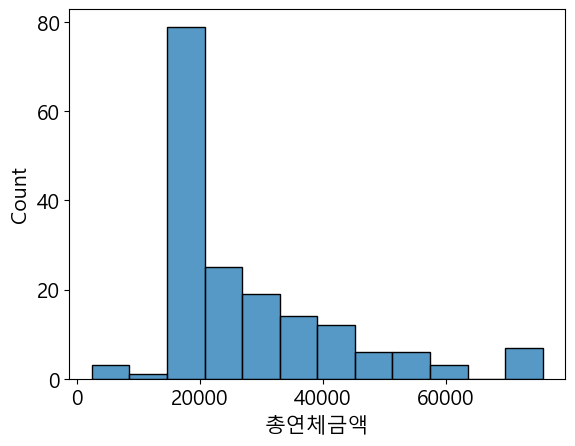

In [72]:
sns.histplot(data=train_prep[train_prep['총연체금액']!=0], x='총연체금액')

### 학습 모델을 이용한 스케일링
- 수치형 데이터: '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
- 표준화(sd_sc): '연간소득'?, '부채_대비_소득_비율'? ->조금 애매함 튜터님과 상의
- 정규화(mm_sc): '대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'

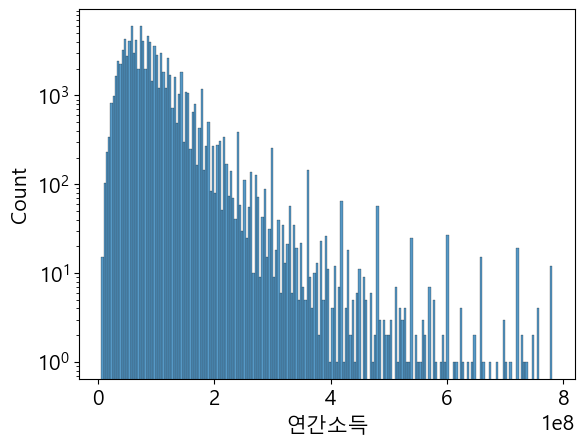

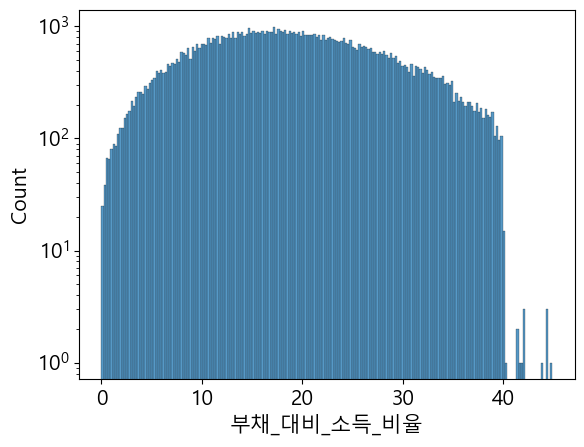

In [73]:
for plot_col in ['연간소득', '부채_대비_소득_비율']:
    sns.histplot(train_prep, x=plot_col, bins=200)
    plt.yscale('log')  # y축을 로그 스케일로 변환
    plt.show()

In [74]:
def get_numeric_sc(X_train:pd.DataFrame, X_test:pd.DataFrame):
    """데이터를 전달받아 수치형 변수 스케일링하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임

    Returns:
        pd.DataFrame, pd.DataFrame: train, test 데이터프레임
    """
    # 수치형변수
    # '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
    #StandardScaler 적용할 변수 리스트 (이부분도 자동화 할 수 있으면 하면 좋을듯)
    sc_col = ['연간소득', '부채_대비_소득_비율']
    #MinMaxScaler 적용할 변수 리스트
    mm_col = ['대출금액', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
    
    #모델 가져오기
    sd_sc = StandardScaler()
    mm_sc = MinMaxScaler()

    #train, test 데이터변환(Standard Scaler이용)
    sd_sc.fit(X_train[sc_col])
    X_train[sc_col] = sd_sc.transform(X_train[sc_col])  #컬럼추가안해주고 바로 바꾸는지?
    X_test[sc_col] = sd_sc.transform(X_test[sc_col])
    
    #train, test 데이터변환(MinMax Scaler이용)
    mm_sc.fit(X_train[mm_col])
    X_train[mm_col] = mm_sc.transform(X_train[mm_col])
    X_test[mm_col] = mm_sc.transform(X_test[mm_col])
    
    return X_train, X_test

In [75]:
def get_numeric_sc(data_train:pd.DataFrame = train_prep, data_test:pd.DataFrame = real_test):
    """데이터를 전달받아 수치형 변수 스케일링하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임

    Returns:
        pd.DataFrame, pd.DataFrame: train, test 데이터프레임
    """
    # 수치형변수
    # '대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'
    #StandardScaler 적용할 변수 리스트
    sc_col = ['연간소득', '부채_대비_소득_비율']
    #MinMaxScaler 적용할 변수 리스트
    mm_col = [num_col for num_col in numeric_col if num_col not in sc_col]
    
    #모델 가져오기
    sd_sc = StandardScaler()
    mm_sc = MinMaxScaler()

    #train, test 데이터변환(Standard Scaler이용)
    sd_sc.fit(data_train[sc_col])
    data_train[sc_col] = sd_sc.transform(data_train[sc_col])  #컬럼추가안해주고 바로 바꾸는지?
    data_test[sc_col] = sd_sc.transform(data_test[sc_col])
    
    #train, test 데이터변환(MinMax Scaler이용)
    mm_sc.fit(data_train[mm_col])
    data_train[mm_col] = mm_sc.transform(data_train[mm_col])
    data_test[mm_col] = mm_sc.transform(data_test[mm_col])
    
    return data_train, data_test

## 인코딩
- y 변수 인코딩: 
- 순서가 중요한 순서형 데이터: (map이나 다른 패키지의 모듈 사용)
- 레이블 인코딩: 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
- 원-핫 인코딩 : 주택소유상태, 대출목적
	- get_dummy:
	- 원-핫 인코딩:

### y 변수 인코딩
일단은 dict와 map을 이용해서 인코딩해주었음     
매칭시켜준 값은 y_dict = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}로 임시로 해뒀음 -> 더 좋은 아이디어가 있을지?     
굳이 인코딩 안해주고 문자열인 채로 그대로 입력해줄 예정

In [76]:
# 일단 y값 어떤 것이 있는지 다시 확인
print(train_prep[target].value_counts())
print(train_prep[target].info())

대출등급
B    28651
C    27462
A    16699
D    13259
E     7298
F     1918
G      400
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 95687 entries, 0 to 96293
Series name: 대출등급
Non-Null Count  Dtype   
--------------  -----   
95687 non-null  category
dtypes: category(1)
memory usage: 841.3 KB
None


In [77]:
# # y 변수 인코딩 함수
# # def get_multiple_categories(x):

# # y값 매칭해줄 정보 딕셔너리    
# y_dict = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7} # {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
target_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
    
# # 확인용 미리 저장
# #y_train_original = y_train.copy()
# #y_test_original = y_test.copy()

# # y_train 데이터 인코딩 코드
# train_prep['대출등급_en'] = train_prep[target].map(y_dict)
# # y_test 데이터 인코딩코드
# train_prep['대출등급_en'] = train_prep[target].map(y_dict)

In [78]:
# train_prep[target,'대출등급_en'].info()

### 범주형 데이터 전처리 (인코딩)
from category_encoders 의 OrdinalEncoder 나 binaryEncoder같은 것 사용할 듯		
->좀더 고민을 해보긴 해야할듯
- 범주형 데이터: '대출기간', '근로기간', '주택소유상태', '대출목적'   
우선적으로 그냥 get_dummies로 하고 시간 여유가 된다면 후에 더 건드려볼듯 함	
	
- 순서가 중요한 순서형 데이터 (map이나 다른 패키지의 모듈 사용(from category_encoders import OrdinalEncoder)) : 	
	- 대출기간, 근로기간 정도 생각은 하고 있음
- 레이블 인코딩(le): 대출기간, 근로기간 (순서나 관계가 있는 경우에는 이 두 가지 외의 다른 인코딩을 해주어야할 수도 있는듯 함)
- 원-핫 인코딩(oe): 주택소유상태, 대출목적	
	둘중 하나로 통일해서 전부 해볼 듯하다   
	- get_dummy:
	- 원-핫 인코딩:

In [79]:
train_prep['근로기간'].cat.categories

Index(['Unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years',
       '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'],
      dtype='object')

In [80]:
def get_category1(data_train:pd.DataFrame, data_test:pd.DataFrame):
    """ 데이터를 전달받아 범주형 변수 더미화하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임
        # 컬럼 리스트를 4가지로 받아서 각 순서, 레이블, get_dummies, 원핫으로 사용할 수 있게 구현시켜볼 예정
    Returns:
        pd.DataFrame, pd.DataFrmae, list: train, test 데이터프레임, 더미화된 컬럼
    """
    #범주형 컬럼 더미화 하기
    train_dummies = pd.get_dummies(data_train[category_col+additional_category_col])
    test_dummies = pd.get_dummies(data_test[category_col+additional_category_col])
    
    # 아래 xgb부분에서 feature_name에 특수기호 들어가면 안된다고 에러가 나서 해당하는 부분 이름 바꿔주기
    # feature_name에 특수기호 + <등 들어가 에러가나서 (get_dummies하는 부분에서 추가된 컬럼들)
    # 나중에 해당부분 get_dummies로 안할경우를 대비해 조건문 등으로 이런 컬럼이 있을 때만 이름을 바꿔주게 설정해줘야함
    if ('근로기간_<1 year' in train_dummies.columns) or ('근로기간_10+ years' in train_dummies.columns):
        rename_dict = {
            '근로기간_<1 year': '근로기간_less_1 year',
            '근로기간_10+ years': '근로기간_10_more years'
        }
        train_dummies.rename(columns=rename_dict, inplace=True)
        test_dummies.rename(columns=rename_dict, inplace=True)
        
        
        # 더미화한 변수를 기존 데이터셋에 합치기
        data_train = pd.concat([data_train, train_dummies], axis = 1)
        data_test = pd.concat([data_test, test_dummies], axis = 1)
    
    return data_train, data_test, train_dummies.columns.to_list()

In [81]:
def get_category(data_train:pd.DataFrame = train_prep, data_test:pd.DataFrame = real_test):
    """ 데이터를 전달받아 범주형 변수 더미화하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임
        # 컬럼 리스트를 4가지로 받아서 각 순서, 레이블, get_dummies, 원핫으로 사용할 수 있게 구현시켜볼 예정
    Returns:
        pd.DataFrame, pd.DataFrmae, list: train, test 데이터프레임, 더미화된 컬럼
    """
    # 범주형 변수: '대출기간', '근로기간', '주택소유상태', '대출목적'
    be_cols = ['대출목적','주택소유상태']
    oe_cols = [cat_col for cat_col in category_col if cat_col not in be_cols] # '대출기간', '근로기간'
    
    # 범주형 컬럼 be하기
    be = ce.BinaryEncoder(cols=be_cols) # handle_unknown='ignore' 기본값 error인데 일단 기본값으로 해봄
    be.fit(data_train[be_cols])
    be_transformed_train = be.transform(data_train[be_cols])  # 애초에 얘도 여러개 생성해서 바로 바꾸는것 안됨
    be_transformed_test = be.transform(data_test[be_cols])
    
    # 원래 DataFrame에서 변환할 열 제거
    # data_train = data_train.drop(be_cols, axis=1)
    # data_test = data_test.drop(be_cols, axis=1)
    
    # 변환된 DataFrame 병합
    data_train = data_train.join(be_transformed_train)
    data_test = data_test.join(be_transformed_test)
    
    # 아래 xgb부분에서 feature_name에 특수기호 들어가면 안된다고 에러가 나서 해당하는 부분 이름 바꿔주기
    # feature_name에 특수기호 + <등 들어가 에러가나서 (get_dummies하는 부분에서 추가된 컬럼들)
    # 나중에 해당부분 get_dummies로 안할경우를 대비해 조건문 등으로 이런 컬럼이 있을 때만 이름을 바꿔주게 설정해줘야함
    # if ('근로기간_<1 year' in train_dummies.columns) or ('근로기간_10+ years' in train_dummies.columns):
    #     rename_dict = {
    #         '근로기간_<1 year': '근로기간_less_1 year',
    #         '근로기간_10+ years': '근로기간_10_more years'
    #     }
    
    oe1 = OrdinalEncoder(categories=[[' 36 months', ' 60 months']],handle_unknown='error')
    oe2 = OrdinalEncoder(categories=[['Unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years','5 years', 
                                      '6 years', '7 years', '8 years', '9 years', '10+ years']],handle_unknown='error')
        
    data_train['대출기간'] = oe1.fit_transform(data_train[['대출기간']])
    data_train['근로기간'] = oe2.fit_transform(data_train[['근로기간']])
    data_test['대출기간'] = oe1.transform(data_test[['대출기간']])
    data_test['근로기간'] = oe2.transform(data_test[['근로기간']])
    #.astype(int) 로 타입 int로 바꾸는 것도 생각
    
    return data_train, data_test, be_transformed_train.columns.to_list()

'''['대출기간_ 36 months','대출기간_ 60 months','근로기간_Unknown','근로기간_less_1 year','근로기간_1 year',
                             '근로기간_2 years','근로기간_3 years','근로기간_4 years','근로기간_5 years','근로기간_6 years','근로기간_7 years',
                             '근로기간_8 years','근로기간_9 years','근로기간_10_more years','주택소유상태_MORTGAGE','주택소유상태_OWN',
                             '주택소유상태_RENT','대출목적_기타','대출목적_부채 통합','대출목적_소규모 사업','대출목적_신용 카드','대출목적_의료',
                             '대출목적_이사','대출목적_자동차','대출목적_재생 에너지','대출목적_주요 구매','대출목적_주택','대출목적_주택 개선',
                             '대출목적_휴가','최근_2년간_연체_여부_no','최근_2년간_연체_여부_yes','연체_여부(총금액)_no','연체_여부(총금액)_yes',
                             '연체_여부(계좌수)_no','연체_여부(계좌수)_yes']'''

### train 데이터 train과 test데이터로 분리
그런데 직접 나눠줄지 아니면 Kfold같은 것 써서 해줄지 고민해봐야할듯     
from sklearn.model_selection import train_test_split를 안쓰고   
cross_val_score나 GridSearchCV, RandomizedSearchCV를 사용하여 어떤 모델이 잘 나오는지 확인해 볼 것 같음

# 모델 수립 및 평가
- 모델은 후보로 염두 중인 것은 로지스터 회귀, 의사결정나무, 랜덤포레스트, knn(최근접이웃), Gradient Boosting, XGBoost, LightGBM     
    ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']
- 우선 일반적으로 이진분류에서 사용하는 평가지표인 <u>정확도</u>, 정밀도, 재현율, <u>F1 점수</u> 사용을 할 것이지만 
    보통 다중 분류에서는 각 클래스에 대한 지표를 계산한 후 평균 내는 방법 등이 추가로 필요하다고 하여 추가 조사 필요
- 전체적으로 다중 분류의 경우 아래와 같이 본 설명이 있어 추가로 이진분류와 어떻게 추가로 다르게 해줘야하는지는 찾아보아야 함
    * 레이블 처리: 이진 분류에서는 대상 변수가 두 가지 범주로 나뉘지만, 다중 분류에서는 대상 변수가 세 개 이상의 범주로 나뉩니다. 따라서 다중 분류 문제에서는 레이블을 적절히 처리해야 합니다.    
    * 성능 측정: 이진 분류에서는 정확도, 정밀도, 재현율, F1 점수 등을 사용하여 모델의 성능을 측정합니다. 다중 분류에서도 이러한 지표를 사용할 수 있지만, 각 클래스에 대한 지표를 계산한 후 이를 평균내는 방법 등이 추가로 필요합니다.     
    * 확률 추정: 일부 알고리즘(예: 로지스틱 회귀)은 이진 분류에서는 시그모이드 함수를, 다중 분류에서는 소프트맥스 함수를 사용하여 클래스 확률을 추정합니다.
    * 손실 함수: 일부 알고리즘(예: SVM, 신경망)은 이진 분류와 다중 분류에서 다른 손실 함수를 사용합니다.

rt의 경우 변수별 중요도를 추출할 수 있어서 그것을 통해 그래프 그리는 기능 추가시켜뒀음

### 변수 중요도 그래프 그리기(함수형태)

In [82]:
# 변수 중요도 그래프 그리기
def draw_feature_importances(feature_importances_df, width_ratios=[3, 1], fontsize=10):
    import matplotlib.gridspec as gridspec
    # Create a figure object
    f = plt.figure(figsize=(15,20))
    
    # Create a gridspec object
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)  # Here, ax1 is three times wider than ax2

    # Create axes using the gridspec object
    ax1 = f.add_subplot(gs[0])
    ax2 = f.add_subplot(gs[1])

    # 레이아웃 조정
    f.subplots_adjust(wspace=0.05)

    # xaxis grid 만들기
    ax1.xaxis.grid()
    ax2.xaxis.grid()

    # 각각의 subplot ax1과 ax2에 barplot 그리기
    ax1 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax1)
    ax2 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax2)
    
    # 각 서브플롯에 대해 막대그래프 끝에 값을 표시
    for p in ax1.patches:
        ax1.annotate(format(p.get_width(), '.4f'), 
                    (p.get_x() + p.get_width(), p.get_y()), 
                    xytext=(0, -9), 
                    textcoords='offset points',
                    ha='left', 
                    va='center', 
                    fontsize=fontsize)

    for p in ax2.patches:
        ax2.annotate(format(p.get_width(), '.4f'), 
                    (p.get_x() + p.get_width(), p.get_y()), 
                    xytext=(0, -9), 
                    textcoords='offset points',
                    ha='left', 
                    va='center', 
                    fontsize=fontsize)
    
    # 축 폰트 크기 설정
    ax1.tick_params(axis='both', labelsize=fontsize*1.2)  # 폰트 크게 조절 #실수float 가능
    ax2.tick_params(axis='both', labelsize=fontsize*1.2)  # 폰트 크게 조절

    # 각 subplot의 축범위 설정 (자동화 가능)
    ax1.set_xlim(0, max(feature_importances_df['importances'])/2)
    ax2.set_xlim(max(feature_importances_df['importances'])/2, max(feature_importances_df['importances']))

    # 각 subplot 눈금 표시하기
    ax1.set_xticks([i/100 for i in range(0, int(max(feature_importances_df['importances'])*100/2), 2)])  # 눈금 간격을 일정하게 조절
    ax2.set_xticks([i/100 for i in range(int(max(feature_importances_df['importances'])*100/2), int(max(feature_importances_df['importances'])*100), 2)])

    # x축 이름 없애줬음 통합해서 붙여줘야함
    ax1.set_xlabel("")
    ax2.set_xlabel("")  # x축 라벨 가운데 정렬

    # x축 label 가운데 위치
    f.text(0.5, 0.08, 'Importances', ha='center', va='center', fontsize=20)
    
    # y축 라벨 설정
    ax1.set_ylabel("Feature Names", fontsize=fontsize*1.4)
    ax2.set_ylabel("")

    # 서로 만나는 부분 y축 선 안보이게 제거
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # 오른 쪽 것의 y축 제거
    ax2.get_yaxis().set_visible(False)

    # 대각선 생략표시
    d = .9    
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

    # y축 값 표시
    ax1.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
    ax2.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
    # y축 눈금 간격 조정
    plt.yticks(fontsize=fontsize*1.2, rotation=30)
    
    # 그래프 제목
    plt.suptitle('Feature Importances', fontsize=fontsize*3, y=0.92)  # 제목 폰트 크게 조절
    
    # 그래프 표시
    plt.show()

# 이제 함수를 호출하여 그래프를 그릴 수 있습니다.


## 모델 적용 및 평가 함수
아마 그러면 이것도 대대적인 공사를 해야할 것 같음       
지금 같은 형태에서 한번에? 패키지 써서 비교하는 식으로 해야할듯

In [83]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list, model_type:str = 'rf', cm_on:bool = True):
    """ train과 test 데이터와 X변수 컬럼을 받아 평가지표를 내는 함수입니다.

    Args:
        train (pd.DataFrame): train 데이터프레임
        test (pd.DataFrame): test 데이터프레임
        x_var_list (list): 모델링에 사용할 변수 리스트
        model_type(str) : 무슨 모델 쓸지 결정 (default : 'rf')
    """
    #외부 전달인자를 내부변수에 할당
    X_train = train 
    X_test = test

    #일부 컬럼만 가져오기
    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    #모델가져오기 & 학습하기    &   # 학습하여 결과 저장
    if model_type in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
        if model_type == 'lor':
            from sklearn.linear_model import LogisticRegression
            model_lor = LogisticRegression()
            model_lor.fit(X_train, y_train['대출등급_en'])
            y_pred_train = model_lor.predict(X_train)
            y_pred_test = model_lor.predict(X_test)
            
        elif model_type == 'dt':
            from sklearn.tree import DecisionTreeClassifier
            model_dt = DecisionTreeClassifier(random_state=42)
            model_dt.fit(X_train, y_train['대출등급_en'])
            y_pred_train = model_dt.predict(X_train)
            y_pred_test = model_dt.predict(X_test)
            
        elif model_type == 'rf':
            from sklearn.ensemble import RandomForestClassifier
            model_rf = RandomForestClassifier(random_state=42)
            model_rf.fit(X_train, y_train['대출등급_en'])
            y_pred_train = model_rf.predict(X_train)
            y_pred_test = model_rf.predict(X_test)
            
            # 변수별 중요도 표시
            feature_names = model_rf.feature_names_in_
            feature_importances = model_rf.feature_importances_
            feature_importances_df = pd.DataFrame({"name": feature_names, "importances": feature_importances})
            #display(feature_importances_df)
            
            # 함수 기능 개선하다가 뭐 잘못조절했는지 자르고나서 큰값 나머지 부분이 그려져야하는데 안그려지는 오류있어서 주석처리해둠
            # 개선 예정
            # import matplotlib.gridspec as gridspec

            # # Create a figure object
            # f = plt.figure(figsize=(15,20))
            
            # # Create a gridspec object
            # gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Here, ax1 is three times wider than ax2

            # # Create axes using the gridspec object
            # ax1 = f.add_subplot(gs[0])
            # ax2 = f.add_subplot(gs[1])

            # # 레이아웃 조정
            # f.subplots_adjust(wspace=0.05)

            # # xaxis grid 만들기
            # ax1.xaxis.grid()
            # ax2.xaxis.grid()

            # # 각각의 subplot ax1과 ax2에 barplot 그리기
            # ax1 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax1)
            # ax2 = sns.barplot(data=feature_importances_df, y='name', x='importances', palette='viridis', orient='h', dodge=False, ax=ax2)
            
            # # 각 서브플롯에 대해 막대그래프 끝에 값을 표시
            # for p in ax1.patches:
            #     ax1.annotate(format(p.get_width(), '.4f'), 
            #                 (p.get_x() + p.get_width(), p.get_y()), 
            #                 xytext=(0, -9), 
            #                 textcoords='offset points',
            #                 ha='left', 
            #                 va='center', 
            #                 fontsize=10)

            # for p in ax2.patches:
            #     ax2.annotate(format(p.get_width(), '.4f'), 
            #                 (p.get_x() + p.get_width(), p.get_y()), 
            #                 xytext=(0, -9), 
            #                 textcoords='offset points',
            #                 ha='left', 
            #                 va='center', 
            #                 fontsize=10)
            
            # # 축 폰트 크기 설정
            # ax1.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절
            # ax2.tick_params(axis='both', labelsize=12)  # 폰트 크게 조절

            # # 각 subplot의 축범위 설정 (자동화 가능)
            # ax1.set_xlim(0, 0.09)
            # ax2.set_xlim(0.32, 0.34)

            # # 각 subplot 눈금 표시하기
            # ax1.set_xticks([0, 0.02, 0.04, 0.06, 0.08])  # 눈금 간격을 일정하게 조절
            # ax2.set_xticks([0.32, 0.34])

            # # x축 이름 없애줬음 통합해서 붙여줘야함
            # ax1.set_xlabel("")
            # ax2.set_xlabel("")  # x축 라벨 가운데 정렬

            # # x축 label 가운데 위치
            # f.text(0.5, 0.08, 'Importances', ha='center', va='center', fontsize=20)
            
            # # y축 라벨 설정
            # ax1.set_ylabel("Feature Names", fontsize=14)
            # ax2.set_ylabel("")

            # # 서로 만나는 부분 y축 선 안보이게 제거
            # ax1.spines['right'].set_visible(False)
            # ax2.spines['left'].set_visible(False)

            # # 오른 쪽 것의 y축 제거
            # ax2.get_yaxis().set_visible(False)

            # # 대각선 생략표시
            # d = .99    
            # kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', clip_on=False)
            # ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
            # ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

            # # y축 값 표시
            # ax1.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            # ax2.set_yticklabels(feature_importances_df['name'], fontsize=12)  # 폰트 크게 조절
            # # y축 눈금 간격 조정
            # plt.yticks(fontsize=12, rotation=30)
            
            # # 그래프 제목
            # plt.suptitle('Feature Importances', fontsize=30, y=0.92)  # 제목 폰트 크게 조절
            
            # # 그래프 표시
            # plt.show()
            #draw_feature_importances(feature_importances_df)
            
        elif model_type == 'knn':
            from sklearn.neighbors import KNeighborsClassifier
            model_knn = KNeighborsClassifier()
            model_knn.fit(X_train, y_train['대출등급_en'])
            y_pred_train = model_knn.predict(X_train)
            y_pred_test = model_knn.predict(X_test)
            
        elif model_type == 'gbm':
            from sklearn.ensemble import GradientBoostingClassifier
            model_gbm = GradientBoostingClassifier(random_state= 42)
            model_gbm.fit(X_train, y_train['대출등급_en'])
            y_pred_train = model_gbm.predict(X_train)
            y_pred_test = model_gbm.predict(X_test)
            
        elif model_type == 'xgb':
            from xgboost import XGBClassifier
            # xgb의 경우에만 인코딩을 0부터 연속적인 클래스 값 써줘야하는 것 같은 느낌?
            # 기존의 클래스 값을 수정하여 새로운 변수에 할당합니다.
            # y_train_xgb_encoded = y_train['대출등급_en'].cat.codes - 1
            # y_test_xgb_encoded = y_test['대출등급_en'].cat.codes - 1
            y_train_xgb_encoded = y_train['대출등급_en'].copy().astype(int) - 1
            y_test_xgb_encoded = y_test['대출등급_en'].copy().astype(int) - 1
            # 아래 예측값 부분도 나올 때 다른 것과 통일 시켜주는 과정 해줘야하는데 이부분도 함수나 변수 등으로 한번에 해주면 좋을 것 같음
            # display(pd.concat([y_train['대출등급_en'], y_train_xgb_encoded], axis = 1))
            model_xgb = XGBClassifier(objective='multi:softprob', random_state= 42, eval_metric='merror')
            # objective='multi:softmax'# mlogloss, merror # , classes=y_dict.values()
            
            model_xgb.fit(X_train, y_train_xgb_encoded)
            # 예측을 수행합니다.
            y_pred_train_xgb = model_xgb.predict(X_train)
            y_pred_test_xgb = model_xgb.predict(X_test)
            
            # XGBoost 모델의 예측값을 +1하여 기존 클래스 값과 일치하도록 합니다.
            y_pred_train = y_pred_train_xgb + 1
            y_pred_test = y_pred_test_xgb + 1
            
            
        elif model_type == 'lgb':
            from lightgbm import LGBMClassifier
            model_lgb = LGBMClassifier(random_state= 42)
            model_lgb.fit(X_train, y_train['대출등급_en'])
            y_pred_train = model_lgb.predict(X_train)
            y_pred_test = model_lgb.predict(X_test)
    
    # 예측된 데이터 형태 int -> category타입으로 변환
    y_pred_train = pd.Series(y_pred_train).astype('category') 
    y_pred_test = pd.Series(y_pred_test).astype('category')

    # 평가표 생성
    result = pd.DataFrame({'acc' : [accuracy_score(y_train['대출등급_en'], y_pred_train), accuracy_score(y_test['대출등급_en'], y_pred_test)],
                           'rec' : [recall_score(y_train['대출등급_en'], y_pred_train, average='macro'), recall_score(y_test['대출등급_en'], y_pred_test, average='macro')],
                           'precision' : [precision_score(y_train['대출등급_en'], y_pred_train, average='macro'), precision_score(y_test['대출등급_en'], y_pred_test, average='macro')],
                            'f1_score' : [f1_score(y_train['대출등급_en'], y_pred_train, average='macro'), f1_score(y_test['대출등급_en'], y_pred_test, average='macro')]},
                            index = ['train','test'])
    # confusion matrix
    if cm_on == True:
        y_encoding_list=list(y_dict.values())
        print("train data")
        display(confusion_matrix(y_train['대출등급_en'], y_pred_train, labels=y_encoding_list))
        display(multilabel_confusion_matrix(y_train['대출등급_en'], y_pred_train, labels=y_encoding_list))
        print("train data")
        display(confusion_matrix(y_test['대출등급_en'], y_pred_test, labels=y_encoding_list))
        display(multilabel_confusion_matrix(y_test['대출등급_en'], y_pred_test, labels=y_encoding_list))
    # balance_accuracy_score는 뭐고, average_precisioin_score라는 것도 있던데 뭔지는 제대로 이해 못함
    print(model_type,"사용시")
    display(result.round(5))

In [169]:
# 중간 진행도 알기 위해서 커스텀 스코어 만들어줌
from sklearn.metrics import f1_score, make_scorer
from datetime import datetime
def custom_f1_macro(y_true, y_pred):
    # f1_macro 점수 계산
    score = f1_score(y_true, y_pred, average='macro')
    
    # 현재 시간과 점수 출력
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"{current_time} Score: {score}")
    
    return score

# 커스텀 스코어러 생성
custom_scorer_f1 = make_scorer(custom_f1_macro)

In [106]:
def model_evaluation(data_train:pd.DataFrame, x_var_list:list):
    """ train과 test 데이터와 X변수 컬럼을 받아 평가지표를 내는 함수입니다.

    Args:
        train (pd.DataFrame): train 데이터프레임
        test (pd.DataFrame): test 데이터프레임
        x_var_list (list): 모델링에 사용할 변수 리스트
        model_type(str) : 무슨 모델 쓸지 결정 (default : 'rf')
    """
    # 모델 생성
    '''model_list = {'model_lor': LogisticRegression(), 'model_dt': DecisionTreeClassifier(random_state=42), 
                'model_rf': RandomForestClassifier(random_state=42), 'model_knn': KNeighborsClassifier(), 
                'model_gbm': GradientBoostingClassifier(random_state= 42), 
                'model_xgb': XGBClassifier(objective='multi:softmax', random_state= 42, eval_metric=['merror', 'mlogloss']), 
                'model_lgb': LGBMClassifier(random_state= 42), 'model_et': ExtraTreesClassifier(random_state=42)}'''
                
    model_list = {'model_dt': DecisionTreeClassifier(random_state=42), 
                'model_rf': RandomForestClassifier(random_state=42), 
                'model_xgb': XGBClassifier(objective='multi:softmax', random_state= 42, eval_metric=['merror', 'mlogloss']), 
                'model_et': ExtraTreesClassifier(random_state=42)}
    
    # 평가지표 설정
    scoring_list = ['accuracy', 'f1_macro']
    results = {}
    fit_model_list={}
    for model_name, model in model_list.items():
        result = cross_validate(estimator=model, X=data_train[x_var_list], y=data_train[target].replace(target_dict), scoring=scoring_list, cv=5, return_train_score=True)
        results[model_name] = result
        # 모델 복제 및 학습
        model_clone = clone(model)
        model_clone.fit(data_train[x_var_list], data_train[target].replace(target_dict))
        # 학습된 모델 저장
        fit_model_list[model_name] = model_clone
    return results, fit_model_list

In [85]:
# # 변수별 중요도 표시
    # feature_names = model_rf.feature_names_in_
    # feature_importances = model_rf.feature_importances_
    # feature_importances_df = pd.DataFrame({"name": feature_names, "importances": feature_importances})
    
    # # 예측된 데이터 형태 int -> category타입으로 변환
    # y_pred_train = pd.Series(y_pred_train).astype('category') 
    # y_pred_test = pd.Series(y_pred_test).astype('category')

In [170]:
def grid_search(data_train:pd.DataFrame, x_var_list:list):
    # 모델들과 하이퍼파라미터 그리드 정의
    models = {
        'model_dt': (DecisionTreeClassifier(random_state=42), {'max_depth': [25, 40]}),
        'model_rf': (RandomForestClassifier(random_state=42), {'n_estimators': [50, 300], 'max_depth': [42, 62]}),
        'model_et': (ExtraTreesClassifier(random_state=42), {'n_estimators': [50, 930], 'max_depth': [65]}),
        'model_xgb': (XGBClassifier(random_state=42), {'n_estimators': [50, 665], 'max_depth': [64]}),
    }
    #'model_lgb': (LGBMClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}), 뭔가 너무 경고나오고 그래서 제외시켜줌
    # 각 모델에 대해 그리드 서치 및 교차 검증 수행
    results = {}
    best_models = {}  # 최적의 모델 저장을 위한 딕셔너리
    cv_results = {}  # cv_results를 저장할 딕셔너리
    scoring ={
        'f1_macro': make_scorer(custom_f1_macro),
        'accuracy': 'accuracy'
    }
    
    for name, (model, param_grid) in models.items():
        print(f"{name}하는 중")
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit=scoring['f1_macro'])
        grid_search.fit(data_train[x_var_list], data_train[target].replace(target_dict))
        results[name] = {
            'best_params': grid_search.best_params_,
            'best_f1_score': grid_search.cv_results_['mean_test_f1_macro'][grid_search.best_index_],
            'best_accuracy': grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],
            'best_scores': grid_search.best_score_, # f1_score 의미
        }
        best_models[name] = grid_search.best_estimator_  # 최적의 모델 저장
        cv_results[name] = grid_search.cv_results_  # cv_results 저장

    # for name, result in results.items():
    #     print(type(result['best_scores']))  # 자료형 확인
    
    # 결과 출력
    for name, result in results.items():
        print(f"Model: {name}")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best F1-macro Score: {result['best_f1_score']}")
        print(f"Best Accuracy Score: {result['best_accuracy']}")
        print(f"Best Score: {result['best_scores']}")
        print()
    return results, best_models, cv_results

In [ ]:
def grid_search(data_train:pd.DataFrame, x_var_list:list):
    # 모델들과 하이퍼파라미터 그리드 정의
    models = {
        'model_dt': (DecisionTreeClassifier(), {'max_depth': [42, 55, 62]}),
        'model_rf': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [42, 55, 62]}),
        'model_et': (ExtraTreesClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [42, 55, 62]}),
        'model_xgb': (XGBClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}),
    }
    #'model_lgb': (LGBMClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}), 뭔가 너무 경고나오고 그래서 제외시켜줌
    # 각 모델에 대해 그리드 서치 및 교차 검증 수행
    results = {}
    best_models = {}  # 최적의 모델 저장을 위한 딕셔너리
    cv_results = {}  # cv_results를 저장할 딕셔너리
    for name, (model, param_grid) in models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=['f1_macro', 'accuracy'], refit='f1_macro')
        grid_search.fit(data_train[x_var_list], data_train[target].replace(target_dict))
        results[name] = {
            'best_params': grid_search.best_params_,
            'best_f1_score': grid_search.cv_results_['mean_test_f1_macro'][grid_search.best_index_],
            'best_accuracy': grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],
            'best_scores': grid_search.best_score_, # f1_score 의미
        }
        best_models[name] = grid_search.best_estimator_  # 최적의 모델 저장
        cv_results[name] = grid_search.cv_results_  # cv_results 저장

    # for name, result in results.items():
    #     print(type(result['best_scores']))  # 자료형 확인
    
    # 결과 출력
    for name, result in results.items():
        print(f"Model: {name}")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best F1-macro Score: {result['best_f1_score']}")
        print(f"Best Accuracy Score: {result['best_accuracy']}")
        print(f"Best Score: {result['best_scores']}")
        print()
    return results, best_models, cv_results

In [171]:
def random_search(data_train:pd.DataFrame, x_var_list:list):
    # 모델들과 하이퍼파라미터 그리드 정의
    models = {
        'model_dt': (DecisionTreeClassifier(random_state=42), {'max_depth': np.arange(40, 70)}),
        'model_rf': (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': np.arange(40, 70)}),
        'model_et': (ExtraTreesClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': np.arange(40, 70)}),
        'model_xgb': (XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': np.arange(40, 70)}),
    }
    #'model_lgb': (LGBMClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}), 뭔가 너무 경고나오고 그래서 제외시켜줌
    # 각 모델에 대해 그리드 서치 및 교차 검증 수행
    results = {}
    best_models = {}  # 최적의 모델 저장을 위한 딕셔너리
    cv_results = {}  # cv_results를 저장할 딕셔너리
    scoring ={
        'f1_macro': make_scorer(custom_f1_macro),
        'accuracy': 'accuracy'
    }
    
    for name, (model, param_grid) in models.items():
        print(f"{name}하는 중")
        random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring=scoring, refit=scoring['f1_macro'], n_iter=10, random_state=42)
        random_search.fit(data_train[x_var_list], data_train[target].replace(target_dict))
        results[name] = {
            'best_params': random_search.best_params_,
            'best_f1_score': random_search.cv_results_['mean_test_f1_macro'][random_search.best_index_],
            'best_accuracy': random_search.cv_results_['mean_test_accuracy'][random_search.best_index_],
            'best_scores': random_search.best_score_, # f1_score 의미
        }
        best_models[name] = random_search.best_estimator_  # 최적의 모델 저장
        cv_results[name] = random_search.cv_results_  # cv_results 저장

    # for name, result in results.items():
    #     print(type(result['best_scores']))  # 자료형 확인
    
    # 결과 출력
    for name, result in results.items():
        print(f"Model: {name}")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best F1-macro Score: {result['best_f1_score']}")
        print(f"Best Accuracy Score: {result['best_accuracy']}")
        print(f"Best Score: {result['best_scores']}")
        print()
    return results, best_models, cv_results

In [148]:
def feature_importance(model_list:dict, remove_keys=['model_dt'], data_train:pd.DataFrame = train_prep, x_var_list:list=numeric_col):
    # 'model_dt' 제외
    model_list = {k: v for k, v in model_list.items() if k not in remove_keys}
    X = data_train[x_var_list]
    # 제외한 모델에 대해 특성 중요도 계산 및 시각화
    for model_name, model in model_list.items():
        importances = model.feature_importances_
        indices = np.argsort(importances)

        # plt.figure(figsize=(10,6))
        # plt.title(f"Feature importances of {model_name}")
        # plt.bar(range(X.shape[1]), importances[indices],color="r", align="center")
        # feature_names = [x_var_list[i] for i in indices]
        # plt.xticks(range(X.shape[1]), feature_names, rotation='vertical')
        # plt.xlim([-1, X.shape[1]])
        # plt.show()
        
        plt.figure(figsize=(10,6))
        plt.title(f"Feature importances of '{model_name}' ")
        bars = plt.barh(range(X.shape[1]), importances[indices], color="r", align="center")
        plt.yticks(range(X.shape[1]), X.columns[indices])
        plt.ylim([-1, X.shape[1]])
        # 각 막대 끝에 중요도 값을 표시
        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}', ha='left', va='center')
        plt.show()

In [164]:
def rfe(data_train:pd.DataFrame, x_var_list:list, models:dict):
    feature_infos = {}  # 특성 정보를 저장할 딕셔너리

    # 각 모델에 대해 RFECV 적용
    for model_name, model in models.items():
        print(f"Model: {model_name}")
        rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring=custom_scorer_f1)
        rfecv.fit(data_train[x_var_list], data_train[target].replace(target_dict))

        print(f"Optimal number of features for {model_name} : {rfecv.n_features_}")

        # 특성 정보 저장
        feature_info = {
            'support': rfecv.support_,
            'ranking': rfecv.ranking_,
            'n_features': rfecv.n_features_
        }
        feature_infos[model_name] = feature_info
        # 특성 중요도 순위 출력
        ranking = sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), x_var_list), reverse=False)
        print("Features sorted by their rank:")
        print(ranking)

    return feature_infos

## 전체 모델링 및 평가
- 하기전에 전처리등 test 데이터에도 동일하게 해줬는지 생각(결측치 등은 몇몇부분은 안해줘야할 것 같기도한데 그부분은 좀더 고민)

#### 위에서 만들어 둔 스케일링과 인코딩 적용

In [87]:
train_prep, real_test = get_numeric_sc(train_prep, real_test)
train_prep, real_test, be_columns = get_category(train_prep, real_test)

In [88]:
pd.set_option('display.max_columns', None)
display(train_prep)
print(be_columns)
real_test

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수),대출목적_0,대출목적_1,대출목적_2,대출목적_3,주택소유상태_0,주택소유상태_1,주택소유상태_2
0,0.276471,0.0,7.0,RENT,-0.352542,-0.042344,0.104762,부채 통합,0.000000,0.000000,0.000000,0.0,0.0,C,no,no,no,0,0,0,1,0,0,1
1,0.323529,1.0,11.0,MORTGAGE,0.662042,0.352171,0.161905,주택 개선,0.000000,0.046652,0.067195,0.0,0.0,B,no,no,no,0,0,1,0,0,1,0
2,0.264706,0.0,6.0,MORTGAGE,0.061574,-1.227040,0.095238,부채 통합,0.000000,0.115971,0.043621,0.0,0.0,A,no,no,no,0,0,0,1,0,1,0
3,0.323529,0.0,9.0,MORTGAGE,0.682747,-0.480566,0.104762,부채 통합,0.000000,0.040689,0.043955,0.0,0.0,C,no,no,no,0,0,0,1,0,1,0
4,0.411765,1.0,0.0,RENT,-0.357097,0.704129,0.142857,주요 구매,0.000000,0.028540,0.042763,0.0,0.0,B,no,no,no,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,0.323529,0.0,11.0,MORTGAGE,2.028623,-1.143076,0.276190,신용 카드,0.000000,0.121707,0.141295,0.0,0.0,C,no,no,no,0,1,1,1,0,1,0
96290,0.676471,1.0,11.0,MORTGAGE,0.682747,-1.622705,0.200000,주택 개선,0.000000,0.072897,0.245483,0.0,0.0,E,no,no,no,0,0,1,0,0,1,0
96291,0.323529,0.0,2.0,MORTGAGE,-0.145484,-0.923390,0.171429,신용 카드,0.000000,0.185965,0.069255,0.0,0.0,A,no,no,no,0,1,1,1,0,1,0
96292,0.352941,0.0,6.0,MORTGAGE,-0.450376,-0.226374,0.161905,부채 통합,0.333333,0.172133,0.234858,0.0,0.0,D,yes,no,no,0,0,0,1,0,1,0


['대출목적_0', '대출목적_1', '대출목적_2', '대출목적_3', '주택소유상태_0', '주택소유상태_1', '주택소유상태_2']


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,최근_2년간_연체_여부,연체_여부(총금액),연체_여부(계좌수),대출목적_0,대출목적_1,대출목적_2,대출목적_3,주택소유상태_0,주택소유상태_1,주택소유상태_2
0,0.382353,0.0,9.0,MORTGAGE,0.682747,0.042770,0.076190,주택 개선,0.000000,0.049290,0.042088,0.0,0.0,no,no,no,0,0,1,0,0,1,0
1,0.176471,0.0,6.0,RENT,-0.042452,-0.394302,0.200000,부채 통합,0.000000,0.000000,0.000000,0.0,0.0,no,no,no,0,0,0,1,0,0,1
2,0.394118,0.0,7.0,RENT,0.993334,-1.248893,0.152381,신용 카드,0.000000,0.223161,0.080907,0.0,0.0,no,no,no,0,1,1,1,0,0,1
3,0.323529,0.0,6.0,MORTGAGE,-0.456071,-0.638142,0.247619,신용 카드,0.166667,0.083549,0.080879,0.0,0.0,yes,no,no,0,1,1,1,0,1,0
4,0.647059,0.0,6.0,RENT,-0.642423,1.291877,0.076190,신용 카드,0.000000,0.156108,0.176513,0.0,0.0,no,no,no,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,0.705882,0.0,4.0,MORTGAGE,-0.249013,0.323417,0.219048,부채 통합,0.333333,0.163287,0.219156,0.0,0.0,yes,no,no,0,0,0,1,0,1,0
64193,0.705882,1.0,11.0,MORTGAGE,0.289338,-0.829074,0.209524,부채 통합,0.000000,0.119963,0.357494,0.0,0.0,no,no,no,0,0,0,1,0,1,0
64194,0.120588,0.0,11.0,RENT,-0.911598,1.096344,0.276190,부채 통합,0.000000,0.016424,0.023220,0.0,0.0,no,no,no,0,0,0,1,0,0,1
64195,0.252941,0.0,11.0,MORTGAGE,-0.456071,0.709880,0.352381,부채 통합,0.166667,0.167283,0.172789,0.0,0.0,yes,no,no,0,0,0,1,0,1,0


#### 모델별 학습 및 평가

In [107]:
model_evaluation_results, evaluation_model_list = model_evaluation(train_prep, numeric_col+be_columns) #일단 위에서 범주형 컬럼 추가해준 부분은 포함안해줬음

In [150]:
model_evaluation_results

{'model_dt': {'fit_time': array([0.66760635, 0.68061948, 0.66260195, 0.66133976, 0.67721105]),
  'score_time': array([0.01201129, 0.01200986, 0.01201129, 0.0119853 , 0.01201081]),
  'test_accuracy': array([0.83603302, 0.83927265, 0.83968229, 0.83550191, 0.84307885]),
  'train_accuracy': array([1., 1., 1., 1., 1.]),
  'test_f1_macro': array([0.77276985, 0.77618444, 0.76610055, 0.7559306 , 0.77350753]),
  'train_f1_macro': array([1., 1., 1., 1., 1.])},
 'model_rf': {'fit_time': array([17.70101905, 17.58146524, 17.64805698, 17.69805861, 17.63227701]),
  'score_time': array([0.43839884, 0.42939043, 0.44840717, 0.4343946 , 0.4584167 ]),
  'test_accuracy': array([0.78153412, 0.78284042, 0.77723781, 0.77676752, 0.7803731 ]),
  'train_accuracy': array([1., 1., 1., 1., 1.]),
  'test_f1_macro': array([0.6583028 , 0.66863208, 0.66285725, 0.64895749, 0.65537035]),
  'train_f1_macro': array([1., 1., 1., 1., 1.])},
 'model_xgb': {'fit_time': array([1.16305661, 1.26852489, 1.26783872, 1.13390422, 1.1

In [151]:
evaluation_model_list

{'model_dt': DecisionTreeClassifier(random_state=42),
 'model_rf': RandomForestClassifier(random_state=42),
 'model_xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=['merror', 'mlogloss'],
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...),
 'model_et': ExtraTreesClassifier(random_state=42)}

In [125]:
grid_search_results, grid_search_best_models, grid_search_cv_results = grid_search(train_prep, numeric_col+be_columns)

model_dt하는 중


model_rf하는 중
model_et하는 중
model_xgb하는 중
Model: model_dt
Best Parameters: {'max_depth': 25}
Best F1-macro Score: 0.7731692142411841
Best Accuracy Score: 0.8412219391303672
Best Score: 0.7731692142411841

Model: model_rf
Best Parameters: {'max_depth': 62, 'n_estimators': 300}
Best F1-macro Score: 0.6721638702582932
Best Accuracy Score: 0.7891353779958867
Best Score: 0.6721638702582932

Model: model_et
Best Parameters: {'max_depth': 65, 'n_estimators': 930}
Best F1-macro Score: 0.577443743681299
Best Accuracy Score: 0.6991649308152584
Best Score: 0.577443743681299

Model: model_xgb
Best Parameters: {'max_depth': 64, 'n_estimators': 50}
Best F1-macro Score: 0.8096816271500844
Best Accuracy Score: 0.8631893746786329
Best Score: 0.8096816271500844



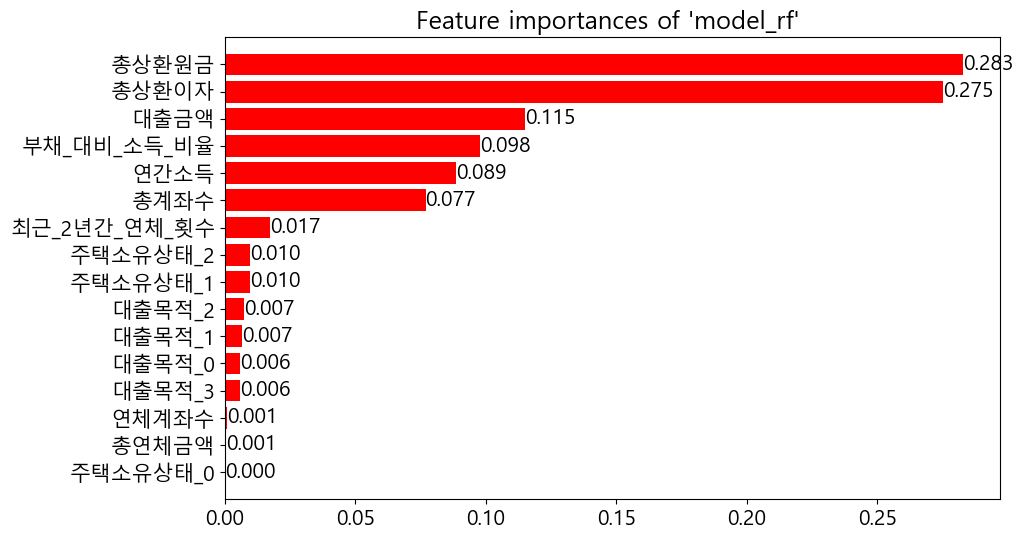

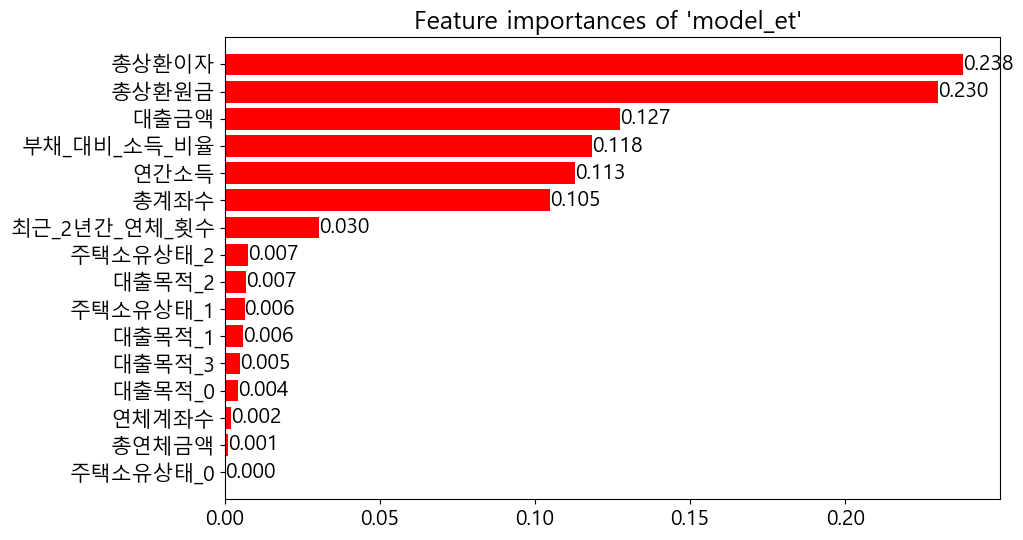

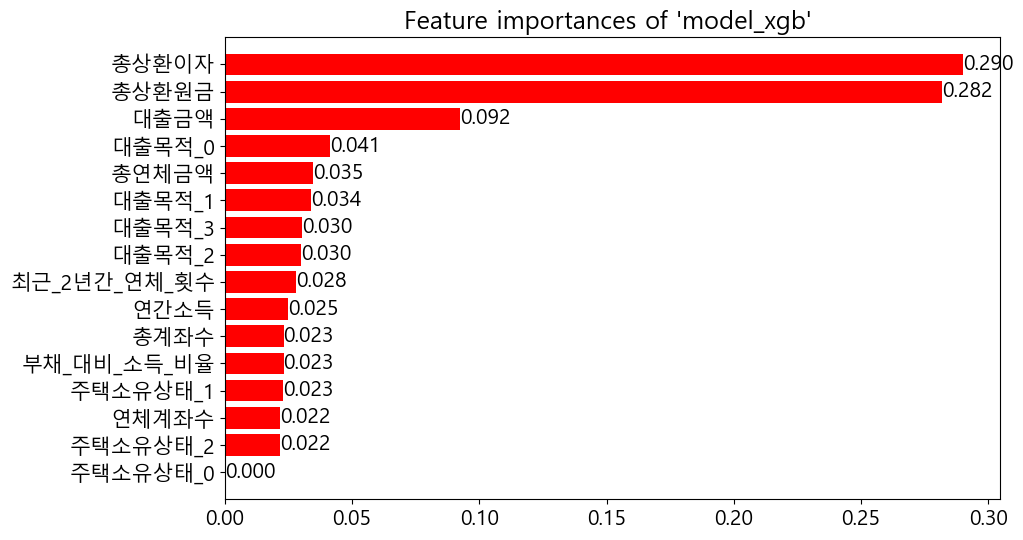

In [149]:
feature_importance(grid_search_best_models, remove_keys=['model_dt'], data_train=train_prep, x_var_list=numeric_col+be_columns)

In [123]:
# random_search_results, random_search_best_models, random_search_cv_results = random_search(train_prep, numeric_col+be_columns)

model_dt하는 중


model_rf하는 중


KeyboardInterrupt: 

In [161]:
grid_search_results

{'model_dt': {'best_params': {'max_depth': 25},
  'best_f1_score': 0.7731692142411841,
  'best_accuracy': 0.8412219391303672,
  'best_scores': 0.7731692142411841},
 'model_rf': {'best_params': {'max_depth': 62, 'n_estimators': 300},
  'best_f1_score': 0.6721638702582932,
  'best_accuracy': 0.7891353779958867,
  'best_scores': 0.6721638702582932},
 'model_et': {'best_params': {'max_depth': 65, 'n_estimators': 930},
  'best_f1_score': 0.577443743681299,
  'best_accuracy': 0.6991649308152584,
  'best_scores': 0.577443743681299},
 'model_xgb': {'best_params': {'max_depth': 64, 'n_estimators': 50},
  'best_f1_score': 0.8096816271500844,
  'best_accuracy': 0.8631893746786329,
  'best_scores': 0.8096816271500844}}

In [160]:
grid_search_best_models

{'model_dt': DecisionTreeClassifier(max_depth=25),
 'model_rf': RandomForestClassifier(max_depth=62, n_estimators=300),
 'model_et': ExtraTreesClassifier(max_depth=65, n_estimators=930),
 'model_xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=64, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=50, n_jobs=None,
               num_parallel_tree=None, objective='multi:softprob', ...)}

In [159]:
models = {
        'model_dt': DecisionTreeClassifier(max_depth=25, random_state=42), 
        'model_rf': RandomForestClassifier(max_depth=62, n_estimators=300, random_state=42), 
        'model_et': ExtraTreesClassifier(max_depth=65, n_estimators=930, random_state=42), 
        'model_xgb': XGBClassifier(max_depth=64, n_estimators=50, random_state=42), 
    }
rfe_feature_infos = rfe(train_prep, numeric_col+be_columns,models=models)

Model: model_dt


Optimal number of features for model_dt : 3
Features sorted by their rank:
[(14, '주택소유상태_0'), (13, '연체계좌수'), (12, '총연체금액'), (11, '대출목적_3'), (10, '대출목적_0'), (9, '대출목적_1'), (8, '주택소유상태_1'), (7, '대출목적_2'), (6, '주택소유상태_2'), (5, '최근_2년간_연체_횟수'), (4, '총계좌수'), (3, '연간소득'), (2, '부채_대비_소득_비율'), (1, '총상환이자'), (1, '총상환원금'), (1, '대출금액')]
Model: model_rf
Optimal number of features for model_rf : 3
Features sorted by their rank:
[(14, '주택소유상태_0'), (13, '총연체금액'), (12, '연체계좌수'), (11, '대출목적_0'), (10, '대출목적_3'), (9, '대출목적_1'), (8, '대출목적_2'), (7, '주택소유상태_1'), (6, '주택소유상태_2'), (5, '최근_2년간_연체_횟수'), (4, '총계좌수'), (3, '연간소득'), (2, '부채_대비_소득_비율'), (1, '총상환이자'), (1, '총상환원금'), (1, '대출금액')]
Model: model_et


MemoryError: could not allocate 4194304 bytes

In [ ]:
loaded_dict = joblib.load('grid_search_best_models.pkl')

##### 필요X부분

In [89]:
# xgb 에러 해결할려고 확인한 부분들
# y_train.info()
# y_train.isna().sum()
# print(y_train['대출등급_en'].unique())
# print(y_dict)
# print(y_dict.values())
# print("X_train의 행 수:", len(X_train))
# print("y_train의 행 수:", len(y_train['대출등급_en']))
# print(X_train.columns)
# print(col_dummies)
# pd.set_option('display.max_columns', None)
# X_train.head(3)

In [90]:
# %%time
# for model in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
#     get_score(X_train, X_test, col_dummies + numeric_col, model_type=model, cm_on =False)
# # get_score(X_train, X_test, col_dummies + numeric_col, model_type='rf')
# # get_score(X_train, X_test, col_dummies + numeric_col, model_type='xgb')

# 추가로 고려해야할 부분

이상치로 판단되어 제외해줬던 부채_대비_소득 비율 9999.0이였던 사람이 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>대출금액</th>
      <th>대출기간</th>
      <th>근로기간</th>
      <th>주택소유상태</th>
      <th>연간소득</th>
      <th>부채_대비_소득_비율</th>
      <th>총계좌수</th>
      <th>대출목적</th>
      <th>최근_2년간_연체_횟수</th>
      <th>총상환원금</th>
      <th>총상환이자</th>
      <th>총연체금액</th>
      <th>연체계좌수</th>
      <th>대출등급</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>12498</th>
      <td>4440000</td>
      <td>36 months</td>
      <td>Unknown</td>
      <td>MORTGAGE</td>
      <td>0</td>
      <td>9999.0</td>
      <td>20</td>
      <td>신용 카드</td>
      <td>2</td>
      <td>205356</td>
      <td>85884.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>C</td>
    </tr>
  </tbody>
</table>
</div>

라는 이상한 형태였다는 것? -> 연간 소득이 0이라서 그리 큰값이 나온듯했음    
연간소득 0 인 사람 저 사람 혼자뿐 그리고 그외 최소 연간소득이 1440000이였음

# y값 디코딩
하고 나서 학습시키고 예측하는 부분만 따로 떼어와서 진짜 X_test값에 대해 예측하는 부분 필요      
아이디와 대출등급 형태로 되어있어야 함

In [94]:
# y값 디코딩부분
# y_answer = y_pred_real_test.map({v: k for k, v in y_dict.items()})